In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr

from scipy.stats import norm

import isolearn.io as isoio

from analyze_leslie_apadb_celltypes_helpers import *


In [2]:
#Load Leslie/APADB data
leslie_tissue_index = np.array(['hek293', 'mcf10a_hras2', 'mcf10a1', 'mcf10a2', 'mcf10a_hras1', 'bcells1', 'mcf7', 'bcells2', 'ovary', 'breast', 'brain', 'skmuscle', 'blcl', 'hES', 'testis', 'hela', 'ntera'], dtype=np.object)
apadb_tissue_index = np.array(['kidney', 'pancreas', 'monocytes', 'all', 'pdac', 'prcc', 'full_blood', 'hlf'], dtype=np.object)

#Load PAS dataframe and cut matrix
native_dict = isoio.load('../data/prepared_data/apa_leslie_apadb_data/apa_leslie_apadb_data')

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned_padded'
pred_dict = isoio.load('predictions/apa_leslie_apadb_data/' + model_name + '_predictions')

#Join measurements with predictions
df, leslie_isoform_count, apadb_isoform_count, leslie_cleavage_count_dict, leslie_cleavage_prob_dict, pred_cleavage_prob = join_pas_dataframes(native_dict, pred_dict, leslie_tissue_index, apadb_tissue_index)

#Load Leslie/APADB pairwise APA dataframe
pair_dict = isoio.load('../data/prepared_data/apa_leslie_apadb_pair_data/apa_leslie_apadb_pair_data')

#Load predictions
model_name = 'aparent_apadb_fitted_legacy_pasaligned_padded'
pair_pred_dict = isoio.load('predictions/apa_leslie_apadb_pair_data/' + model_name + '_predictions')

#Join measurements with predictions
pair_df, leslie_cleavage_count_prox_dict, leslie_cleavage_prob_prox_dict, leslie_cleavage_count_dist_dict, leslie_cleavage_prob_dist_dict, pred_cleavage_prob_prox, pred_cleavage_prob_dist = join_apa_dataframes(pair_dict, pair_pred_dict, leslie_tissue_index, apadb_tissue_index)


In [3]:
#Basic Leslie/APADB Stats

print('Leslie Total Read Count = ' + str(np.sum(df['leslie_count_apadb_region_pooled'])))
print('Leslie Avg Pooled Read Count = ' + str(np.mean(df['leslie_count_apadb_region_pooled'])))
print('Leslie Avg Pooled Read Count (Non-zero) = ' + str(np.mean(df.query("leslie_count_apadb_region_pooled > 0")['leslie_count_apadb_region_pooled'])))
print('Leslie Avg Read Count / Tissue = ' + str(np.mean(leslie_isoform_count)))

print('APADB Total Read Count = ' + str(np.sum(df['apadb_count_pooled'])))
print('APADB Avg Pooled Read Count = ' + str(np.mean(df['apadb_count_pooled'])))
print('APADB Avg Pooled Read Count (Non-zero) = ' + str(np.mean(df.query("apadb_count_pooled > 0")['apadb_count_pooled'])))
print('APADB Avg Read Count / Tissue = ' + str(np.mean(apadb_isoform_count)))


Leslie Total Read Count = 35882341.0
Leslie Avg Pooled Read Count = 690.5230736663844
Leslie Avg Pooled Read Count (Non-zero) = 1783.6825073321072
Leslie Avg Read Count / Tissue = 40.61900433331673
APADB Total Read Count = 16791397.0
APADB Avg Pooled Read Count = 323.13518974674776
APADB Avg Pooled Read Count (Non-zero) = 323.13518974674776
APADB Avg Read Count / Tissue = 40.61097827342006


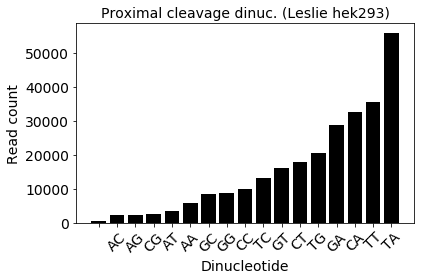

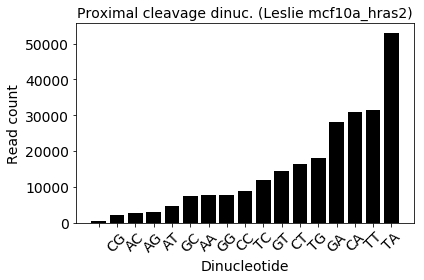

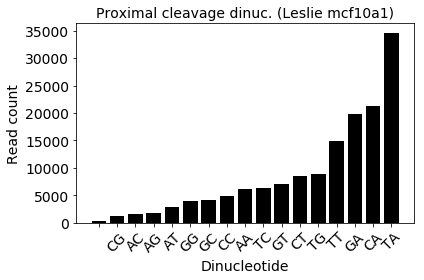

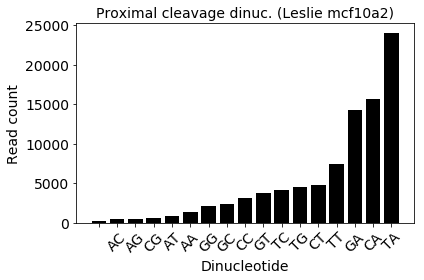

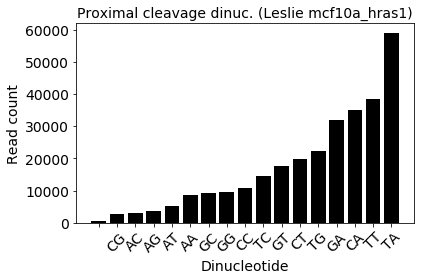

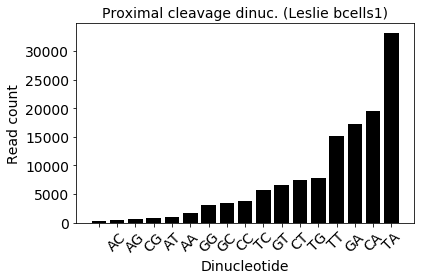

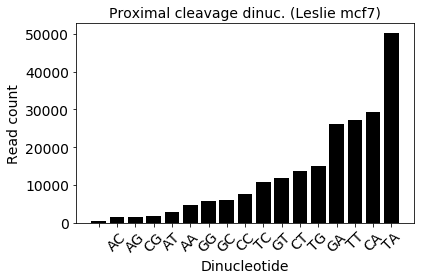

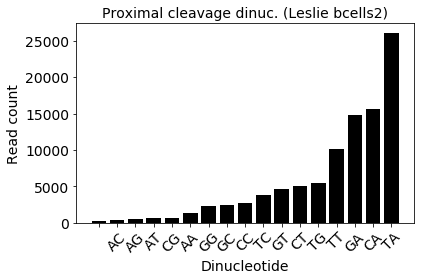

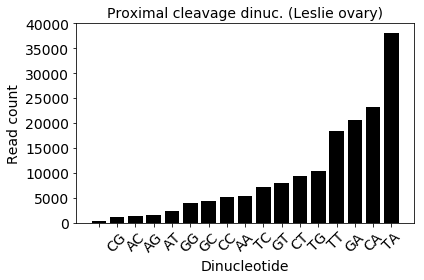

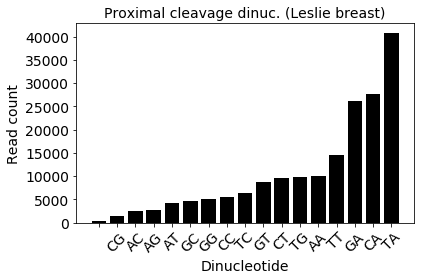

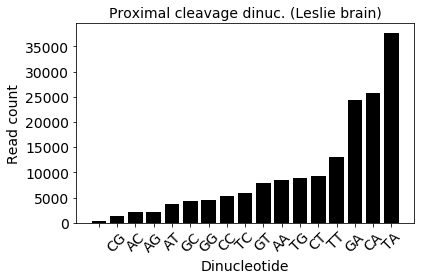

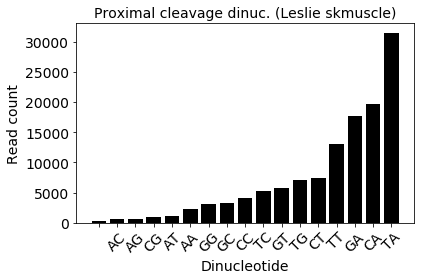

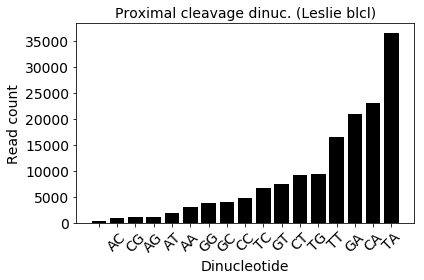

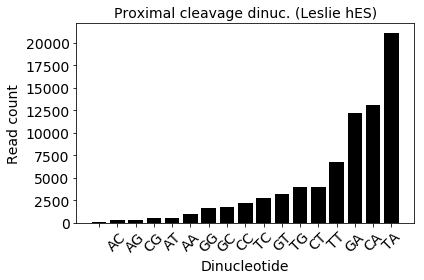

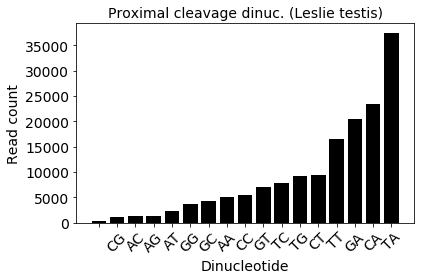

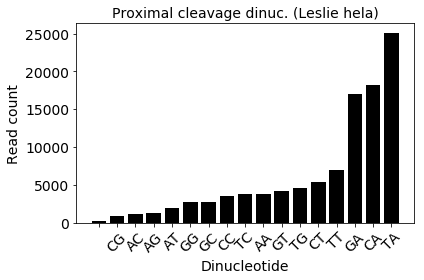

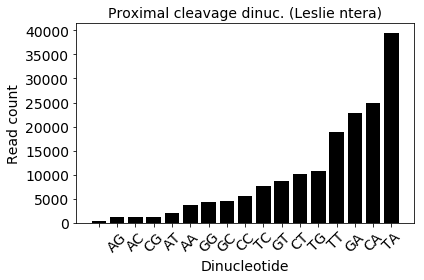

In [4]:
for tissue_i in range(0, len(leslie_tissue_index)) :
    cell_type = leslie_tissue_index[tissue_i]
    plot_cut_2mers(df, cell_type, leslie_cleavage_count_dict[cell_type], seq_column='seq')

Read depth across Leslie pA site measurements (Mean/Pooled across cell types).


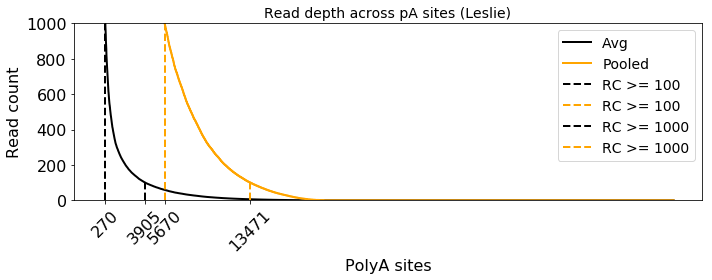

Read depth across APADB pA site measurements (Mean/Pooled across tissues).


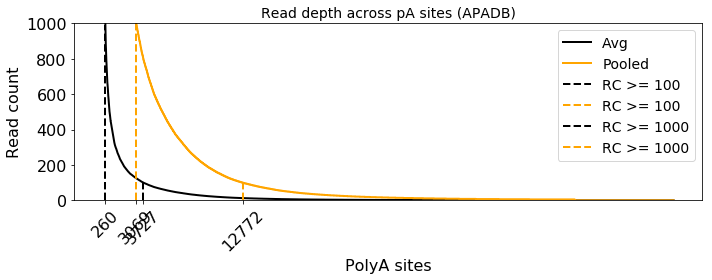

In [8]:
print("Read depth across Leslie pA site measurements (Mean/Pooled across cell types).")
plot_read_coverage_distribution(leslie_isoform_count, 'Leslie')

print("Read depth across APADB pA site measurements (Mean/Pooled across tissues).")
plot_read_coverage_distribution(apadb_isoform_count, 'APADB')

Leslie total read count statistics per cell type.


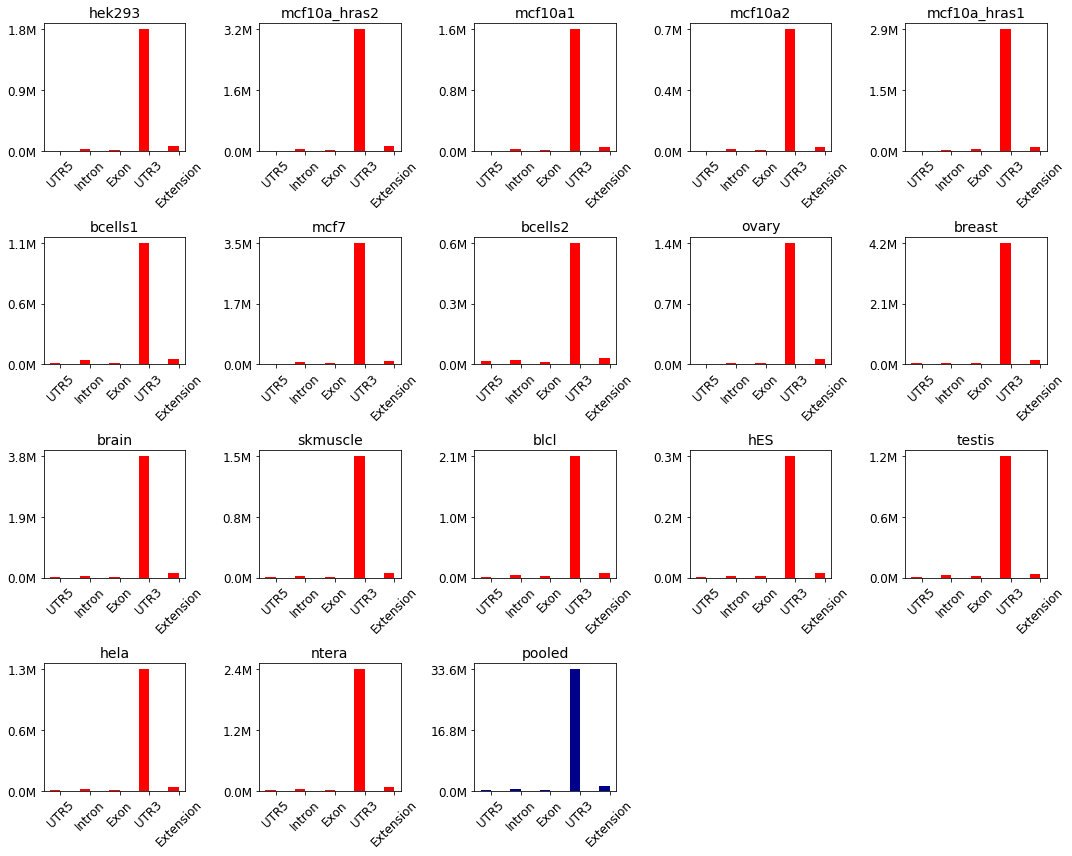

APADB total read count statistics per tissue.


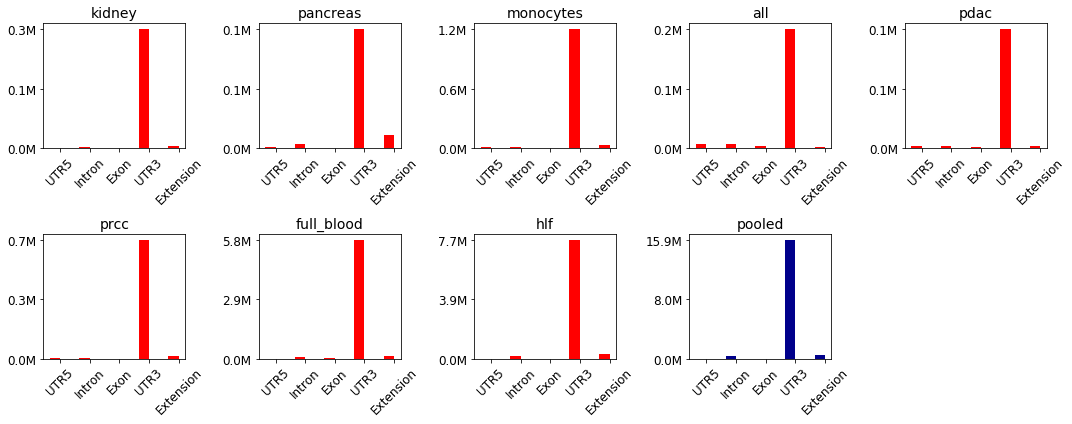

In [6]:
print('Leslie total read count statistics per cell type.')
leslie_tissue_index_extended = np.concatenate([leslie_tissue_index, np.array(['pooled'])])
plot_tissue_read_count_histo(df, 'leslie', leslie_tissue_index_extended, n_rows=4, n_cols=5)

print('APADB total read count statistics per tissue.')
apadb_tissue_index_extended = np.concatenate([apadb_tissue_index, np.array(['pooled'])])
plot_tissue_read_count_histo(df, 'apadb', apadb_tissue_index_extended, n_rows=2, n_cols=5)

Fraction of intronic pA reads across Leslie cell types.


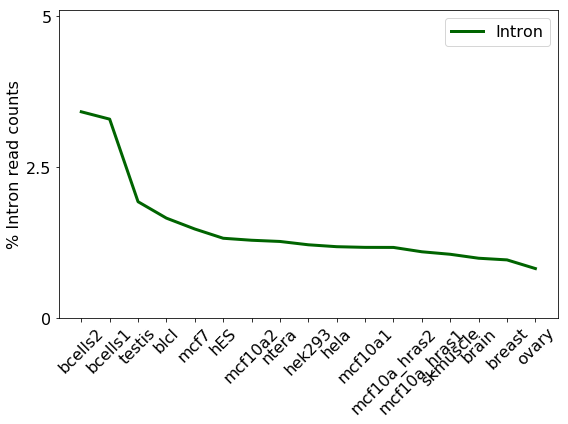

Fraction of intronic pA reads across APADB cell types.


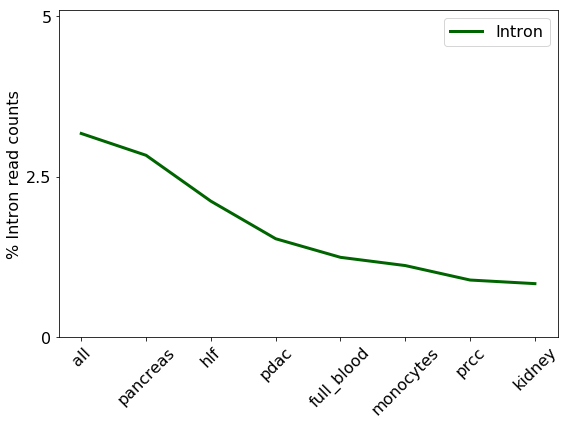

In [7]:
print('Fraction of intronic pA reads across Leslie cell types.')
plot_site_type_fractions(df, 'leslie', leslie_tissue_index)

print('Fraction of intronic pA reads across APADB cell types.')
plot_site_type_fractions(df, 'apadb', apadb_tissue_index)

Leslie total site usage correlation (across cell types, total site usage).


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


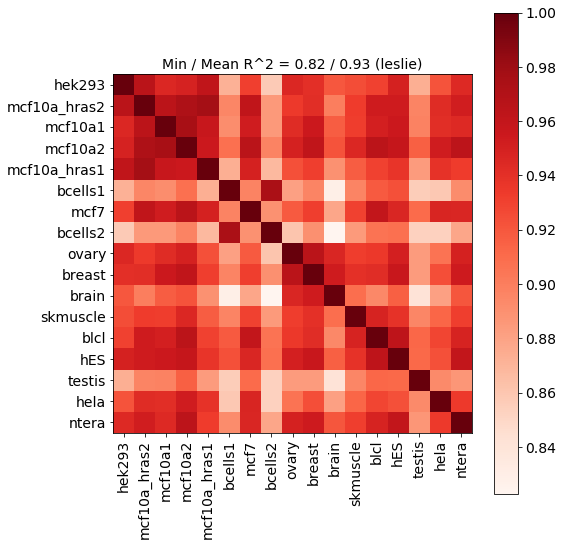

APADB total site usage correlation (across cell types, total site usage).


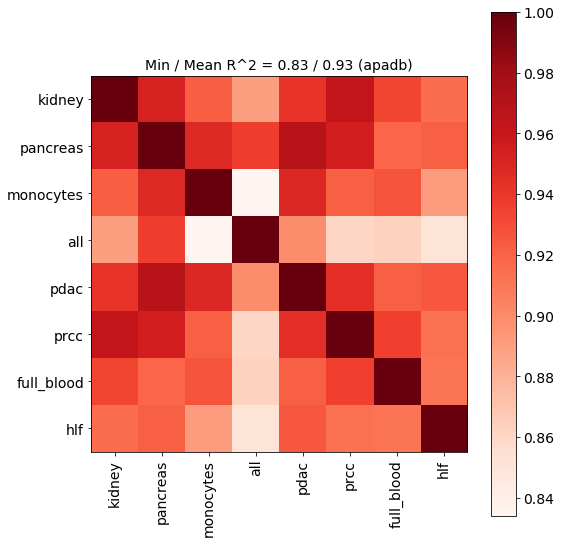

In [6]:
#Differential total site usage analysis
site_nums = None
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1
min_total_count = 20
only_differentials = False
use_logodds = False
fixed_isoform_difference = 0.25


print("Leslie total site usage correlation (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)

print("APADB total site usage correlation (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)


Leslie mean isoform usage difference (across cell types, total site usage).


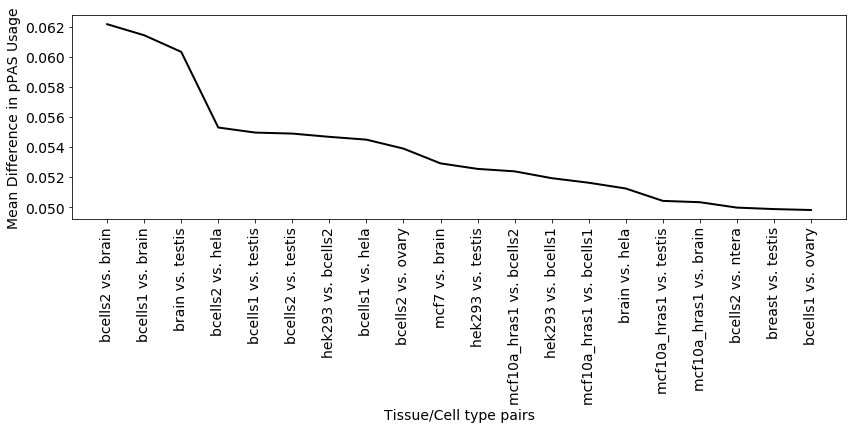

APADB mean isoform usage difference (across cell types, total site usage).


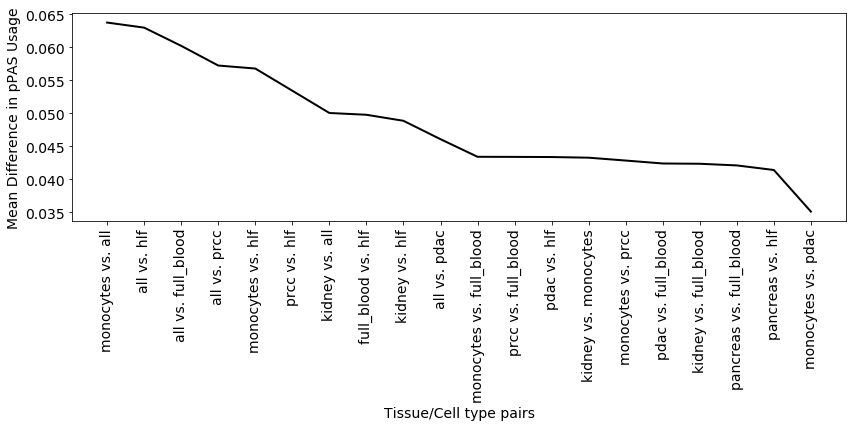

In [10]:
print("Leslie mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)

print("APADB mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)


Leslie fraction of sites with high differential usage (across cell types, total site usage).


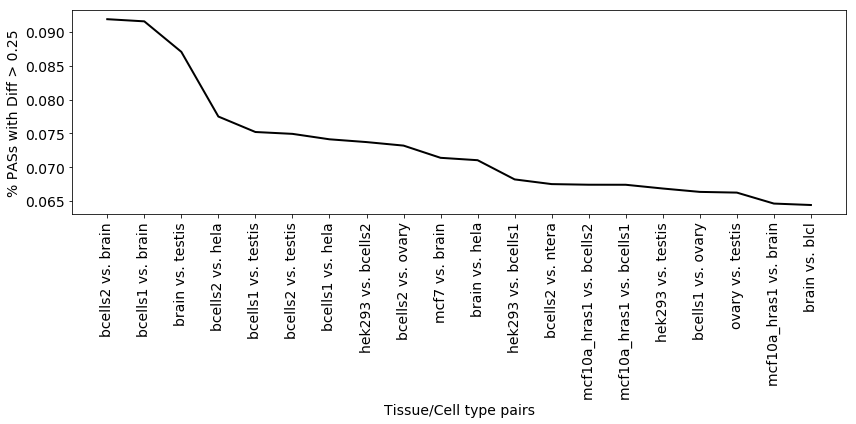

APADB fraction of sites with high differential usage (across cell types, total site usage).


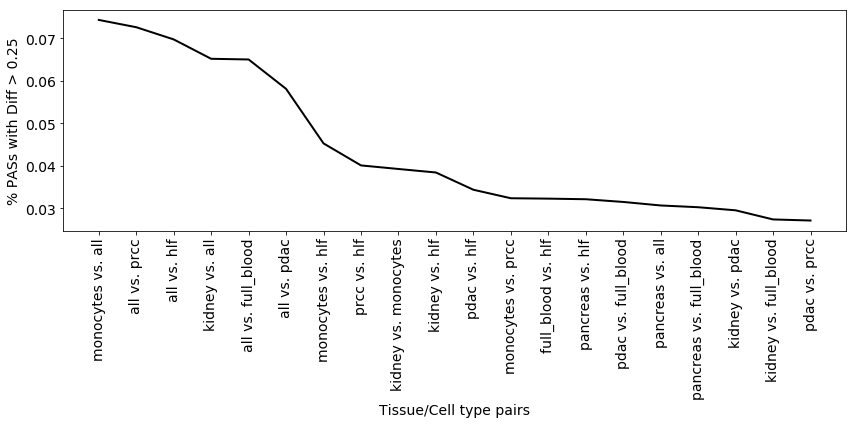

In [9]:
print("Leslie fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)

print("APADB fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)


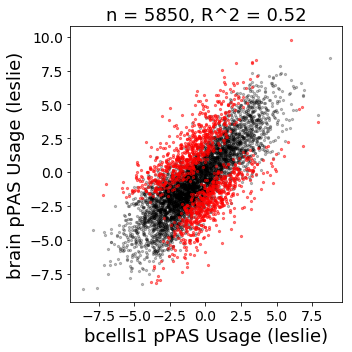

In [4]:
#Differential total site usage analysis, individual scatter
site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3']
pseudo_count = 0.0#0.1#1.0#0.0
min_total_count = 20#100
only_differentials = True
use_logodds = True
color_by_sitenum = False

source_data_1 = 'leslie'
tissue_1 = 'bcells1'
special_mode_1 = '_apadb_region'
tissue_1_info = (source_data_1, tissue_1, special_mode_1)

source_data_2 = 'leslie'
tissue_2 = 'brain'
special_mode_2 = '_apadb_region'
tissue_2_info = (source_data_2, tissue_2, special_mode_2)

plot_individual_differential_scatter(df, tissue_1_info, tissue_2_info, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, total_count_str='total_count', color_significant_sites=True)

Intronic, Exonic and 3' UTR Cleavage distribution pooled across cell types (Leslie data).


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


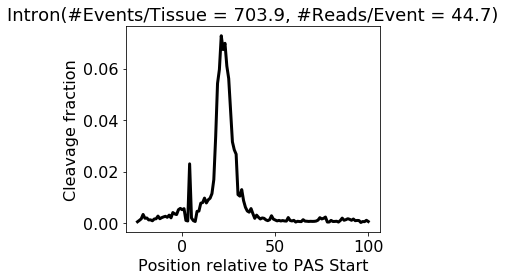

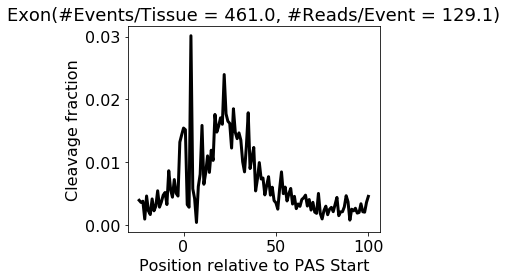

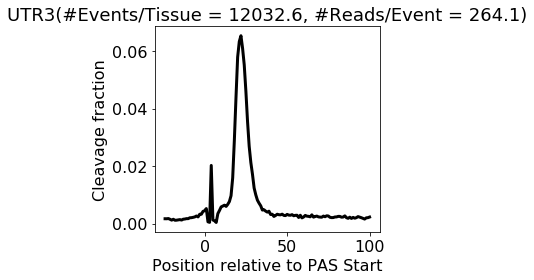

3' UTR Cleavage distribution per cell type (Leslie data).


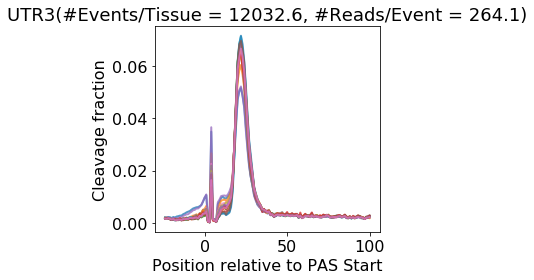

In [4]:
#Mean of normalized cleavage counts, pooled and per cell type of the Leslie dataset

print('Intronic, Exonic and 3\' UTR Cleavage distribution pooled across cell types (Leslie data).')
plot_cut_distributions(df, leslie_tissue_index, leslie_cleavage_count_dict, ['Intron', 'Exon', 'UTR3'], plot_tissue_specific=False, plot_pooled=True)

print('3\' UTR Cleavage distribution per cell type (Leslie data).')
plot_cut_distributions(df, leslie_tissue_index, leslie_cleavage_count_dict, ['UTR3'], plot_tissue_specific=True, plot_pooled=False)


Predicted vs. Observed mean cut position per tissue (scatter dots = PAS sequences).


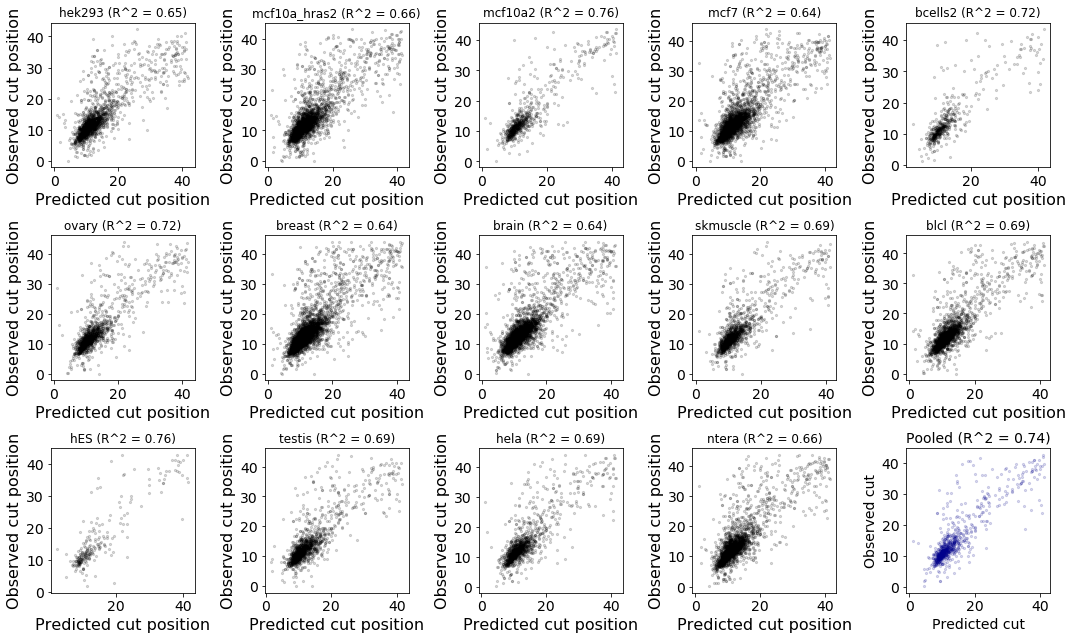

In [5]:
print("Predicted vs. Observed mean cut position per tissue (scatter dots = PAS sequences).")
plot_pred_vs_observed_mean_cut(df, leslie_cleavage_count_dict, pred_cleavage_prob, leslie_tissue_index)

Predicted vs. Observed mean cut position per tissue (correlation bar chart).


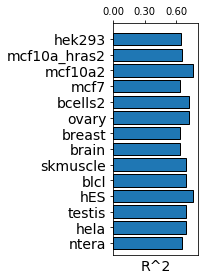

In [6]:
print("Predicted vs. Observed mean cut position per tissue (correlation bar chart).")
plot_pred_vs_observed_mean_cut_bar(df, leslie_cleavage_count_dict, pred_cleavage_prob, leslie_tissue_index)

Leslie pair-wise APA site usage correlation (across cell types).


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


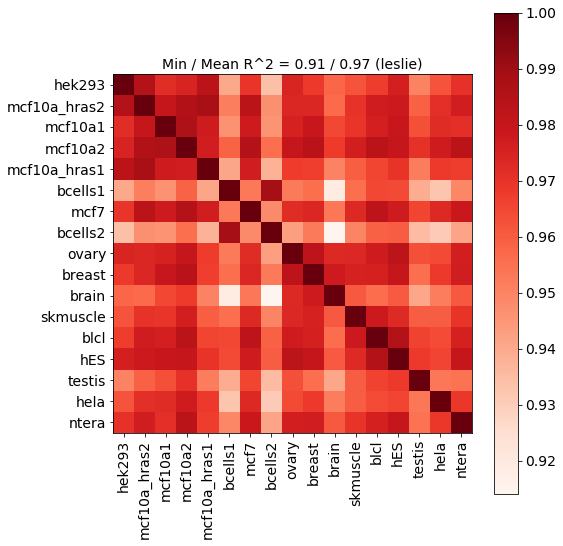

APADB pair-wise APA site usage correlation (across cell types).


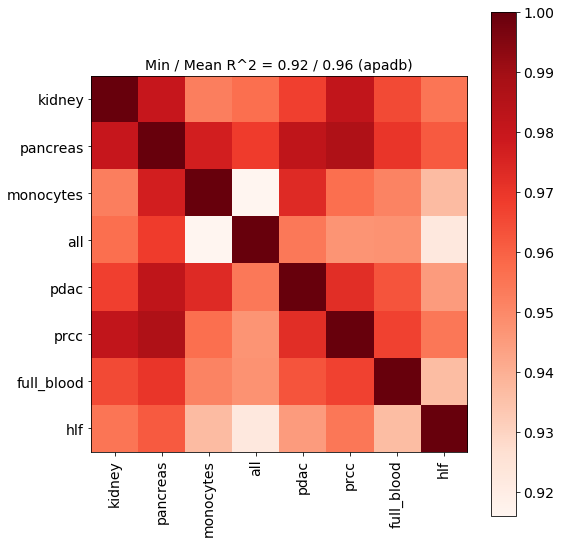

In [3]:
#Differential pair-wise APA site usage analysis
site_nums = None
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1
min_total_count = 20
only_differentials = False
use_logodds = False
fixed_isoform_difference = 0.25


print("Leslie pair-wise APA site usage correlation (across cell types).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)

print("APADB pair-wise APA site usage correlation (across cell types).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)


Leslie mean isoform usage difference (across cell types, total site usage).


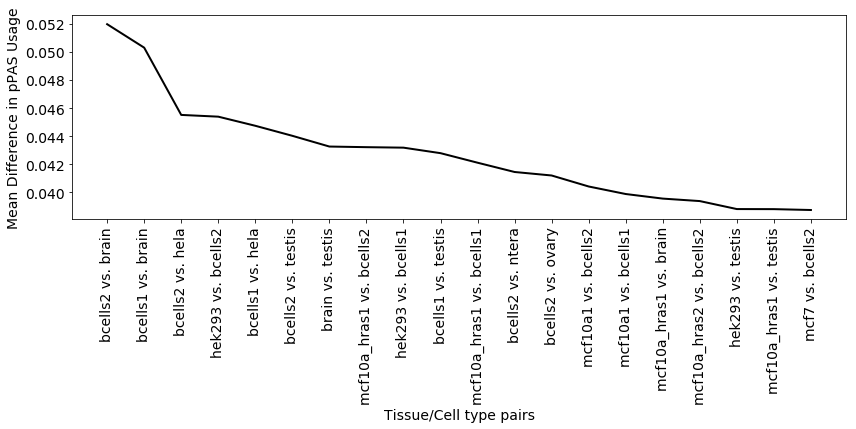

APADB mean isoform usage difference (across cell types, total site usage).


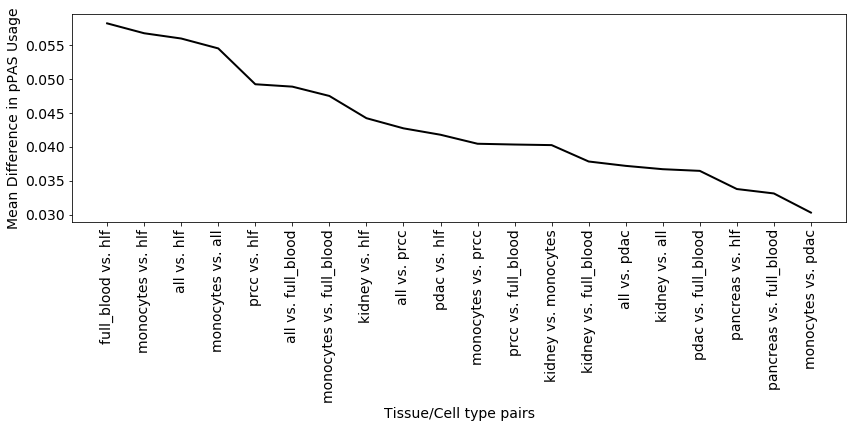

In [4]:
print("Leslie mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)

print("APADB mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)


Leslie fraction of sites with high differential usage (across cell types, total site usage).


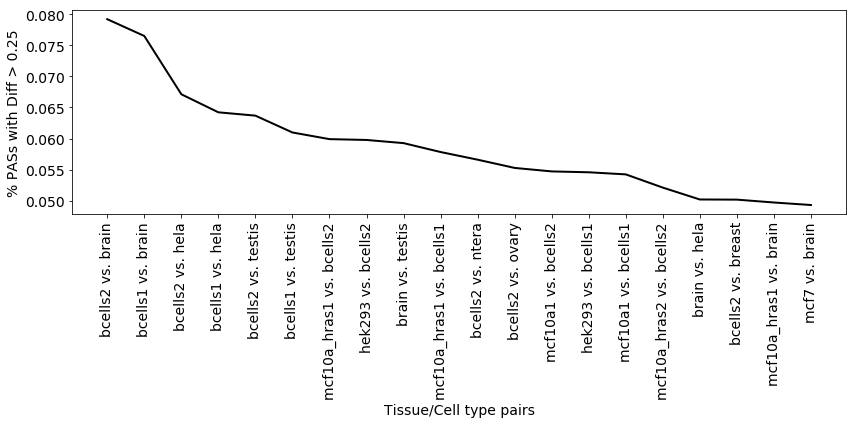

APADB fraction of sites with high differential usage (across cell types, total site usage).


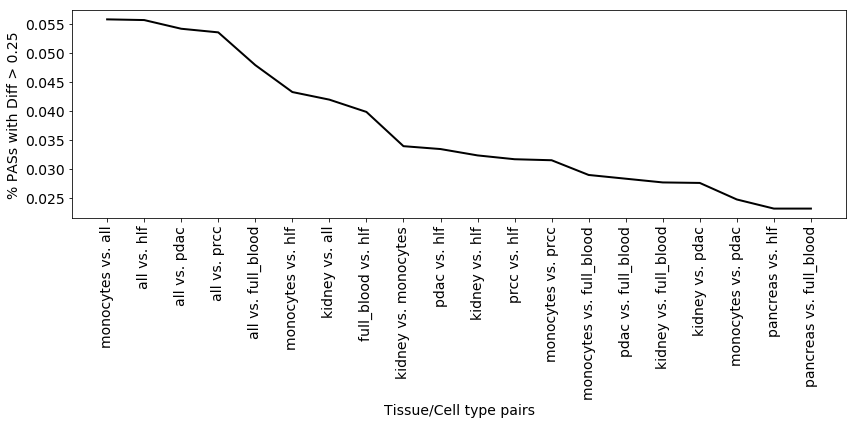

In [5]:
print("Leslie fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)

print("APADB fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)


In [12]:
def k_fold_optimize_linear(k, X, y, l2_lambdas=None, l1_lambdas=None, debias_l1=False, min_params=1, max_params=1000) :
    min_loss = np.inf
    min_param = 0
    
    if l2_lambdas is not None :
        for l2_lambda in l2_lambdas :
            total_loss, _ = k_fold_cross_linear(k, X, y, l2_lambda=l2_lambda, l1_lambda=None)
            if total_loss < min_loss :
                min_loss = total_loss
                min_param = l2_lambda
    elif l1_lambdas is not None :
        for l1_lambda in l1_lambdas :
            _, _, _, _, w_bundle = fit_linear_model(X, y, X, y, l2_lambda=None, l1_lambda=l1_lambda)
            w, _ = w_bundle
            n_nonzero = len(np.nonzero(w)[0])
            total_loss = np.inf
            if n_nonzero > 0 :
                if not debias_l1 :
                    total_loss, _ = k_fold_cross_linear(k, X, y, l2_lambda=None, l1_lambda=l1_lambda)
                else :
                    total_loss, _ = k_fold_cross_linear(k, X[:, w != 0], y, l2_lambda=None, l1_lambda=None)

            if total_loss < min_loss and n_nonzero >= min_params and n_nonzero <= max_params :
                min_loss = total_loss
                min_param = l1_lambda
            
            print(str(l1_lambda) + ' = ' + str(total_loss))
    
    return min_loss, min_param

def k_fold_optimize_logistic(k, X, y, l2_lambdas=None) :
    min_loss = np.inf
    min_param = 0
    
    if l2_lambdas is not None :
        for l2_lambda in l2_lambdas :
            total_loss, _ = k_fold_cross_logistic(k, X, y, l2_lambda=l2_lambda, l1_lambda=None)
            if total_loss < min_loss :
                min_loss = total_loss
                min_param = l2_lambda
    
    return min_loss, min_param


def k_fold_cross_linear(k, X, y, l2_lambda=None, l1_lambda=None) :
    n_batches = k
    batch_size = int(X.shape[0] / float(k))
    if batch_size * k < X.shape[0] - 1 :
        n_batches += 1
    
    total_loss = 0
    total_y_hat = []
    
    for batch_index in range(n_batches) :
        X_train = None
        y_train = None
        X_test = None
        y_test = None
        if batch_index < n_batches - 1 :
            
            if batch_index == 0 :
                X_train = X[(batch_index + 1) * batch_size:, :]
                y_train = y[(batch_index + 1) * batch_size:]
            elif isinstance(X, sp.csr_matrix) or isinstance(X, sp.csc_matrix) :
                X_train = sp.vstack([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]])
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            else :
                X_train = np.concatenate([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]], axis=0)
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            
            X_test = X[batch_index * batch_size: (batch_index + 1) * batch_size, :]
            y_test = y[batch_index * batch_size: (batch_index + 1) * batch_size]
        else :
            
            X_train = X[:batch_index * batch_size, :]
            y_train = y[:batch_index * batch_size]
            
            X_test = X[batch_index * batch_size:, :]
            y_test = y[batch_index * batch_size:]
        
        y_test_hat, sse, _, _, _ = fit_linear_model(X_train, y_train, X_test, y_test, l2_lambda, l1_lambda)
        
        total_loss += sse
        total_y_hat.append(y_test_hat)
    
    total_y_hat = np.concatenate(total_y_hat, axis=0)
    
    return total_loss, total_y_hat

def k_fold_cross_logistic(k, X, y, l2_lambda=None) :
    n_batches = k
    batch_size = int(X.shape[0] / float(k))
    if batch_size * k < X.shape[0] - 1 :
        n_batches += 1
    
    total_loss = 0
    total_y_hat = []
    
    for batch_index in range(n_batches) :
        X_train = None
        y_train = None
        X_test = None
        y_test = None
        if batch_index < n_batches - 1 :
            
            if batch_index == 0 :
                X_train = X[(batch_index + 1) * batch_size:, :]
                y_train = y[(batch_index + 1) * batch_size:]
            elif isinstance(X, sp.csr_matrix) or isinstance(X, sp.csc_matrix) :
                X_train = sp.vstack([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]])
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            else :
                X_train = np.concatenate([X[:(batch_index - 1) * batch_size, :], X[(batch_index + 1) * batch_size:, :]], axis=0)
                y_train = np.concatenate([y[:(batch_index - 1) * batch_size], y[(batch_index + 1) * batch_size:]])
            
            X_test = X[batch_index * batch_size: (batch_index + 1) * batch_size, :]
            y_test = y[batch_index * batch_size: (batch_index + 1) * batch_size]
        else :
            
            X_train = X[:batch_index * batch_size, :]
            y_train = y[:batch_index * batch_size]
            
            X_test = X[batch_index * batch_size:, :]
            y_test = y[batch_index * batch_size:]
        
        y_test_hat, kldiv, _, _, _ = fit_logistic_model(X_train, y_train, X_test, y_test, l2_lambda)
        
        total_loss += kldiv
        total_y_hat.append(y_test_hat)
    
    total_y_hat = np.concatenate(total_y_hat, axis=0)
    
    return total_loss, total_y_hat
    

def fit_linear_model(X_train, y_train, X_test, y_test, l2_lambda=None, l1_lambda=None) :
    
    lr = sklinear.LinearRegression()
    if l2_lambda is not None :
        lr = sklinear.Ridge(alpha=l2_lambda)
    elif l1_lambda is not None :
        lr = sklinear.Lasso(alpha=l1_lambda)
    
    lr.fit(X_train, y_train)
    
    y_test_hat = lr.predict(X_test)
    
    SSE = (y_test - y_test_hat).T.dot(y_test - y_test_hat)
    y_test_average = np.average(y_test, axis=0)
    SStot = (y_test - y_test_average).T.dot(y_test - y_test_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y_test) == np.sign(y_test_hat))) / float(X_test.shape[0])
    
    return y_test_hat, SSE, rsquare, accuracy, (lr.coef_, lr.intercept_)

def predict_linear_model(X, w, w_0) :
    return X.dot(w) + w_0

def fit_logistic_model(X_train, y_train, X_test, y_test, l2_lambda=None) :
    
    f_loss = lambda w_bundle, X=X_train, y_true=y_train, alpha=l2_lambda: kl_div_loss(w_bundle, X, y_true, alpha)
    f_grad = lambda w_bundle, X=X_train, y_true=y_train, alpha=l2_lambda: kl_div_gradients(w_bundle, X, y_true, alpha)
    w_bundle_init = np.zeros(X_train.shape[1] + 1)
    res = minimize(f_loss, w_bundle_init, method='BFGS', jac=f_grad, options={'disp': False})

    w_bundle = res.x
    w_0 = w_bundle[0]
    w = w_bundle[1:]

    y_test_hat = get_y_pred(X_test, w, w_0)
    
    SSE = (y_test - y_test_hat).T.dot(y_test - y_test_hat)
    y_test_average = np.average(y_test, axis=0)
    SStot = (y_test - y_test_average).T.dot(y_test - y_test_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y_test) == np.sign(y_test_hat))) / float(X_test.shape[0])
    
    return y_test_hat, kl_div_loss(w_bundle, X_test, y_test, alpha=l2_lambda) * float(X_test.shape[0]), rsquare, accuracy, (w, w_0)

def predict_logistic_model(X, w, w_0) :
    return get_y_pred(X, w, w_0)

def fit_loocv_model(X, y, l2_lambda=None) :
    lr = sklinear.LinearRegression()
    if l2_lambda is not None :
        lr = sklinear.Ridge(alpha=l2_lambda)

    y_hat = cross_val_predict(lr, X, y, cv=X.shape[0])

    SSE = (y - y_hat).T.dot(y - y_hat)
    y_average = np.average(y, axis=0)
    SStot = (y - y_average).T.dot(y - y_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])
    
    lr.fit(X, y)
    
    return y_hat, rsquare, accuracy, (lr.coef_, lr.intercept_)

def predict_with_model(X, y, weight_bundle) :
    lr = sklinear.LinearRegression()
    lr.coef_ = weight_bundle[0]
    lr.intercept_ = weight_bundle[1]
    
    y_hat = lr.predict(X)

    SSE = (y - y_hat).T.dot(y - y_hat)
    y_average = np.average(y, axis=0)
    SStot = (y - y_average).T.dot(y - y_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])
    
    return y_hat, rsquare, accuracy






def safe_kl_log(num, denom) :
    log_vec = np.zeros(num.shape)
    log_vec[(num > 0) & (denom > 0)] = np.log(num[(num > 0) & (denom > 0)] / denom[(num > 0) & (denom > 0)])
    
    return log_vec

def get_y_pred(X, w, w_0) :
    score = X.dot(w) + w_0
    return 1. / (1. + np.exp(-score))

def kl_div_loss(w_bundle, X, y_true, alpha=0.0) :
    w_0 = w_bundle[0]
    w = w_bundle[1:]
    
    y_pred = get_y_pred(X, w, w_0)
    kl = y_true * safe_kl_log(y_true, y_pred) + (1. - y_true) * safe_kl_log((1. - y_true), (1. - y_pred)) + (1./2.) * alpha * np.dot(w, w)
    
    return np.mean(kl)

def kl_div_gradients(w_bundle, X, y_true, alpha=0.0) :
    w_0 = w_bundle[0]
    w = w_bundle[1:]
    N = float(X.shape[0])
    y_pred = get_y_pred(X, w, w_0)
    
    kl_grad_w = (1. / N) * X.T.dot(y_pred - y_true) + alpha * w
    kl_grad_w_0 = (1. / N) * np.sum(y_pred - y_true)
    
    w_bundle_grads = np.zeros(w.shape[0] + 1)
    w_bundle_grads[0] = kl_grad_w_0
    w_bundle_grads[1:] = kl_grad_w
    
    return w_bundle_grads


def get_6mer_features(df, seq_col, seq_start, seq_end) :
    mer6_dict = {}
    bases = ['A', 'C', 'G', 'T']
    
    i = 0
    for b1 in bases :
        for b2 in bases :
            for b3 in bases :
                for b4 in bases :
                    for b5 in bases :
                        for b6 in bases :
                            mer6_dict[b1 + b2 + b3 + b4 + b5 + b6] = i
                            i += 1
    
    X_mer = sp.lil_matrix((len(df), 4096))
    
    i = 0
    for _, row in df.iterrows() :
        region = row[seq_col][seq_start:seq_end]
        
        for j in range(0, len(region) - 6 + 1) :
            X_mer[i, mer6_dict[region[j:j+6]]] += 1
        
        i += 1
    
    return sp.csr_matrix(X_mer)

def get_pas_features(df, seq_col, seq_start, seq_end) :
    pas_dict = {}
    
    unique_pases = df[seq_col].str.slice(50, 56).unique()
    
    i = 0
    for unique_pas in unique_pases :
        pas_dict[unique_pas] = i
        i += 1
    
    X_mer = sp.lil_matrix((len(df), len(unique_pases)))
    
    i = 0
    for _, row in df.iterrows() :
        region = row[seq_col][seq_start:seq_end]
        
        for j in range(0, len(region) - 6 + 1) :
            X_mer[i, pas_dict[region[j:j+6]]] += 1
        
        i += 1
    
    return sp.csr_matrix(X_mer)

def get_4mer_features(df, seq_col, seq_start, seq_end) :
    mer4_dict = {}
    bases = ['A', 'C', 'G', 'T']
    
    i = 0
    for b1 in bases :
        for b2 in bases :
            for b3 in bases :
                for b4 in bases :
                    mer4_dict[b1 + b2 + b3 + b4] = i
                    i += 1
    
    X_mer = sp.lil_matrix((len(df), 256))
    
    i = 0
    for _, row in df.iterrows() :
        region = row[seq_col][seq_start:seq_end]
        
        for j in range(0, len(region) - 4 + 1) :
            X_mer[i, mer4_dict[region[j:j+4]]] += 1
        
        i += 1
    
    return sp.csr_matrix(X_mer)


In [25]:
site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3']
pseudo_count = 0.5
min_total_count = 1500#500#20
max_cut_region = 60
min_distance = 40
max_distance = 4000
only_differentials = True

use_deep_features = False

source_data = 'leslie'
tissue = 'pooled'
special_mode = '_apadb_region'#'_apadb_region'
pred_special_mode = '_apadb_region'

count_col = source_data + '_count' + special_mode + '_' + tissue + '_prox'
total_count_col = source_data + '_pair_count' + special_mode + '_' + tissue

df_to_use = df_pair_filtered.query(total_count_col + " >= " + str(min_total_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")

df_to_use = df_to_use.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df_to_use = df_to_use.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")

isoform_ratio = (df_to_use[count_col] + pseudo_count) / (df_to_use[total_count_col] + 2. * pseudo_count)
isoform_logodds = np.log(isoform_ratio / (1. - isoform_ratio))


prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)

deep_prox = deep_features_prox[np.ravel(df_to_use['row_index']), :]
deep_dist = deep_features_dist[np.ravel(df_to_use['row_index']), :]
if use_deep_features :
    prox_score = deep_prox
    dist_score = deep_dist

X = np.concatenate([
    prox_score,
    dist_score,
    distance,
], axis=1)

y = isoform_logodds


In [1182]:

X_4mer_up_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 0, 50))
X_4mer_dn_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 57, 100))
X_6mer_up_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 0, 50))
X_6mer_dn_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 57, 100))
X_pas_prox = sp.csc_matrix(get_pas_features(df_to_use, 'seq_prox', 50, 56))

X_4mer_up_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 0, 50))
X_4mer_dn_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 57, 100))
X_6mer_up_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 0, 50))
X_6mer_dn_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 57, 100))
X_pas_dist = sp.csc_matrix(get_pas_features(df_to_use, 'seq_dist', 50, 56))

X_sparse = sp.csc_matrix(X)
#X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_pas_prox, X_4mer_up_dist, X_4mer_dn_dist, X_pas_dist]))
#X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_pas_prox, X_pas_dist]))
X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_4mer_up_dist, X_4mer_dn_dist, X_6mer_up_prox, X_6mer_dn_prox, X_6mer_up_dist, X_6mer_dn_dist]))


In [26]:
train_set_frac=0.75

X_train = X[:int(X.shape[0] * train_set_frac), :]
y_train = y[:int(X.shape[0] * train_set_frac)]

X_test = X[X_train.shape[0]:, :]
y_test = y[X_train.shape[0]:]

n = 354
LOOCV R^2: 0.49
LOOCV accuracy = 0.78


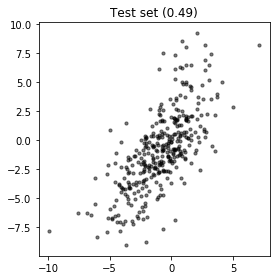

# non-zero weights = 3


In [32]:

y_test_hat, sse, rsquare, accuracy, weight_bundle = fit_linear_model(X_train, y_train, X_test, y_test, l1_lambda=None) #0.035

print("n = " + str(y_test.shape[0]))
print("LOOCV R^2: %0.2f" % (rsquare))

print('LOOCV accuracy = ' + str(round(accuracy, 2)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, alpha=0.5, c='black', s=10)

plt.title('Test set (' + str(round(rsquare, 2)) + ')')
plt.tight_layout()

plt.savefig('leslie_pooled_testset_scatter.png', transparent=True, dpi=150)
plt.savefig('leslie_pooled_testset_scatter.eps')
plt.show()

w, w_0 = weight_bundle

print('# non-zero weights = ' + str(len(np.nonzero(w)[0])))


n = 1415
LOOCV R^2: 0.46
LOOCV accuracy = 0.76


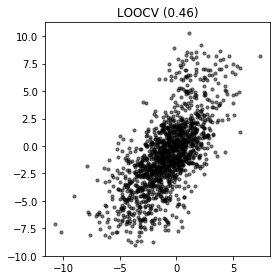

In [34]:

y_hat, rsquare, accuracy, weight_bundle = fit_loocv_model(X, y, l2_lambda=None)

print("n = " + str(X.shape[0]))
print("LOOCV R^2: %0.2f" % (rsquare))

print('LOOCV accuracy = ' + str(round(accuracy, 2)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_hat, y, alpha=0.5, c='black', s=10)

plt.title('LOOCV (' + str(round(rsquare, 2)) + ')')
plt.tight_layout()

plt.savefig('leslie_pooled_loocv_scatter.png', transparent=True, dpi=150)
plt.savefig('leslie_pooled_loocv_scatter.eps')
plt.show()




n = 1415
LOOCV R^2: 0.46
LOOCV accuracy = 0.76


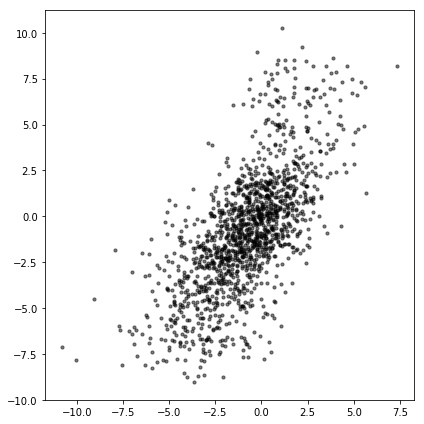

In [29]:

_, y_hat = k_fold_cross_linear(50, X, y, l2_lambda=None, l1_lambda=None)

SSE = (y - y_hat).T.dot(y - y_hat)
y_average = np.average(y, axis=0)
SStot = (y - y_average).T.dot(y - y_average)
rsquare = 1.0 - (SSE / SStot)

accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])

print("n = " + str(X.shape[0]))
print("LOOCV R^2: %0.2f" % (rsquare))

print('LOOCV accuracy = ' + str(round(accuracy, 2)))

f = plt.figure(figsize=(6, 6))

plt.scatter(y_hat, y, alpha=0.5, c='black', s=10)

plt.tight_layout()
plt.show()




In [28]:
#Start of multiplex analysis

site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.5
min_total_apadb_count = 10#500#20
min_total_leslie_count = 10
max_cut_region = 60
min_distance = 40
max_distance = 4000
only_differentials = False

apadb_total_count_col = 'apadb_total_count_pooled'
leslie_total_count_col = 'leslie_total_count_apadb_region_pooled'

#Apply global pre-filters
df_to_use = df_pair_filtered.query(apadb_total_count_col + " >= " + str(min_total_apadb_count))
df_to_use = df_to_use.query(leslie_total_count_col + " >= " + str(min_total_leslie_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]
if only_differentials :
    df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")
df_to_use = df_to_use.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df_to_use = df_to_use.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")

df_to_use = df_to_use.query("mirna_prox == mirna_dist")

#Shuffle dataframe

shuffle_index = np.arange(len(df_to_use))
np.random.shuffle(shuffle_index)

df_all = df_to_use.iloc[shuffle_index].copy().reset_index(drop=True)

print('Total size = ' + str(len(df_all)))

#Split into training and test data

train_set_frac = 0.5

df_train = df_all.iloc[:int(len(df_all) * train_set_frac)]
df_test = df_all.iloc[len(df_train):]

print('Train size = ' + str(len(df_train)))
print('Test size = ' + str(len(df_test)))


Total size = 15912
Train size = 7956
Test size = 7956


In [29]:
def get_data(df, source_data, tissue, special_mode, pred_special_mode, pseudo_count=0.5, min_total_count=20, only_differentials=False) :
    count_col = source_data + '_count' + special_mode + '_' + tissue + '_prox'
    total_count_col = source_data + '_pair_count' + special_mode + '_' + tissue

    df_to_use = df.query(total_count_col + " >= " + str(min_total_count))
    if only_differentials :
        df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")

    total_count = np.ravel(df_to_use[total_count_col].values)
    y_ratio = (df_to_use[count_col] + pseudo_count) / (df_to_use[total_count_col] + 2. * pseudo_count)
    y_logodds = np.log(y_ratio / (1. - y_ratio))

    prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
    dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
    distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)

    X = np.concatenate([
        prox_score,
        dist_score,
        distance
    ], axis=1)

    return X, y_ratio, y_logodds, total_count, df_to_use


In [30]:
#Initialize results

tissue_results_dict = {}

In [31]:
print(apadb_tissue_index)
print(leslie_tissue_index)

['kidney' 'pancreas' 'monocytes' 'all' 'pdac' 'prcc' 'full_blood' 'hlf']
['hek293' 'mcf10a_hras2' 'mcf10a1' 'mcf10a2' 'mcf10a_hras1' 'bcells1'
 'mcf7' 'bcells2' 'ovary' 'breast' 'brain' 'skmuscle' 'blcl' 'hES'
 'testis' 'hela' 'ntera']


In [32]:

count_filters = {
    'apadb_pooled' : 1000,
    'apadb_kidney' : 20,
    'apadb_pancreas' : 10,
    'apadb_monocytes' : 20,
    'apadb_all' : 20,
    'apadb_pdac' : 20,
    'apadb_prcc' : 20,
    'apadb_full_blood' : 500,
    'apadb_hlf' : 500,
    
    'leslie_pooled' : 1000,
    'leslie_hek293' : 50,
    'leslie_mcf10a_hras2' : 50,
    'leslie_mcf10a1' : 50,
    'leslie_mcf10a2' : 50,
    'leslie_mcf10a_hras1' : 50,
    'leslie_bcells1' : 50,
    'leslie_mcf7' : 50,
    'leslie_bcells2' : 50,
    'leslie_ovary' : 50,
    'leslie_breast' : 50,
    'leslie_brain' : 50,
    'leslie_skmuscle' : 50,
    'leslie_blcl' : 50,
    'leslie_hES' : 50,
    'leslie_testis' : 50,
    'leslie_hela' : 50,
    'leslie_ntera' : 50
}


In [33]:
#Fit on APADB pooled, predict on everything

X_apadb, y_ratio_apadb, y_logodds_apadb, count_apadb, df_apadb = get_data(df_all, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=False)
X_apadb_train, y_ratio_apadb_train, y_logodds_apadb_train, count_apadb_train, df_apadb_train = get_data(df_train, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=False)
X_apadb_test, y_ratio_apadb_test, y_logodds_apadb_test, count_apadb_test, df_apadb_test = get_data(df_test, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=False)

_, _, _, _, w_bundle_linear = fit_linear_model(X_apadb, y_logodds_apadb, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)
w_linear, w_linear_0 = w_bundle_linear

_, _, _, _, w_bundle_logistic = fit_logistic_model(X_apadb, y_ratio_apadb, X_apadb, y_ratio_apadb, l2_lambda=0.0)
w_logistic, w_logistic_0 = w_bundle_logistic

y_logodds_apadb_test_hat, _, _, _, w_bundle_linear_train = fit_linear_model(X_apadb_train, y_logodds_apadb_train, X_apadb_test, y_logodds_apadb_test, l2_lambda=None, l1_lambda=None)
w_linear_train, w_linear_0_train = w_bundle_linear_train

y_ratio_apadb_test_hat, _, _, _, w_bundle_logistic_train = fit_logistic_model(X_apadb_train, y_ratio_apadb_train, X_apadb_test, y_ratio_apadb_test, l2_lambda=0.0)
w_logistic_train, w_logistic_0_train = w_bundle_logistic_train


_, y_logodds_apadb_hat = k_fold_cross_linear(50, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)

_, y_ratio_apadb_hat = k_fold_cross_logistic(50, X_apadb, y_ratio_apadb, l2_lambda=0.0)

tissue_results_dict['apadb_pooled'] = {}
tissue_results_dict['apadb_pooled']['apadb_pooled'] = {}
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds'] = y_logodds_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio'] = y_ratio_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds_hat'] = y_logodds_apadb_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio_hat'] = y_ratio_apadb_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds_test'] = y_logodds_apadb_test
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio_test'] = y_ratio_apadb_test
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_logodds_test_hat'] = y_logodds_apadb_test_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_ratio_test_hat'] = y_ratio_apadb_test_hat
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_count'] = count_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['y_count_test'] = count_apadb_test
tissue_results_dict['apadb_pooled']['apadb_pooled']['df'] = df_apadb
tissue_results_dict['apadb_pooled']['apadb_pooled']['df_test'] = df_apadb_test

for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled']['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled']['leslie_' + tissue] = {}
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled']['leslie_' + tissue]['df_test'] = df_tissue_test


In [34]:
#Fit on APADB pooled, predict on everything, differentials only

X_apadb, y_ratio_apadb, y_logodds_apadb, count_apadb, df_apadb = get_data(df_all, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)
X_apadb_train, y_ratio_apadb_train, y_logodds_apadb_train, count_apadb_train, df_apadb_train = get_data(df_train, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)
X_apadb_test, y_ratio_apadb_test, y_logodds_apadb_test, count_apadb_test, df_apadb_test = get_data(df_test, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)

_, _, _, _, w_bundle_linear = fit_linear_model(X_apadb, y_logodds_apadb, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)
w_linear, w_linear_0 = w_bundle_linear

_, _, _, _, w_bundle_logistic = fit_logistic_model(X_apadb, y_ratio_apadb, X_apadb, y_ratio_apadb, l2_lambda=0.0)
w_logistic, w_logistic_0 = w_bundle_logistic

y_logodds_apadb_test_hat, _, _, _, w_bundle_linear_train = fit_linear_model(X_apadb_train, y_logodds_apadb_train, X_apadb_test, y_logodds_apadb_test, l2_lambda=None, l1_lambda=None)
w_linear_train, w_linear_0_train = w_bundle_linear_train

y_ratio_apadb_test_hat, _, _, _, w_bundle_logistic_train = fit_logistic_model(X_apadb_train, y_ratio_apadb_train, X_apadb_test, y_ratio_apadb_test, l2_lambda=0.0)
w_logistic_train, w_logistic_0_train = w_bundle_logistic_train


_, y_logodds_apadb_hat = k_fold_cross_linear(50, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)

_, y_ratio_apadb_hat = k_fold_cross_logistic(50, X_apadb, y_ratio_apadb, l2_lambda=0.0)

tissue_results_dict['apadb_pooled_differential'] = {}
tissue_results_dict['apadb_pooled_differential']['apadb_pooled'] = {}
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds'] = y_logodds_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio'] = y_ratio_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds_hat'] = y_logodds_apadb_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio_hat'] = y_ratio_apadb_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds_test'] = y_logodds_apadb_test
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio_test'] = y_ratio_apadb_test
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_logodds_test_hat'] = y_logodds_apadb_test_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_ratio_test_hat'] = y_ratio_apadb_test_hat
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_count'] = count_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['y_count_test'] = count_apadb_test
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['df'] = df_apadb
tissue_results_dict['apadb_pooled_differential']['apadb_pooled']['df_test'] = df_apadb_test

for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    
    if X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled_differential']['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    
    if X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_hat = predict_linear_model(X_tissue, w_linear, w_linear_0)
    
    y_ratio_tissue_hat = predict_logistic_model(X_tissue, w_logistic, w_logistic_0)
    
    y_logodds_tissue_test_hat = predict_linear_model(X_tissue_test, w_linear_train, w_linear_0_train)
    
    y_ratio_tissue_test_hat = predict_logistic_model(X_tissue_test, w_logistic_train, w_logistic_0_train)

    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue] = {}
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_pooled_differential']['leslie_' + tissue]['df_tissue_test'] = df_tissue_test


In [35]:
#Fit and predict on individual tissues


for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=False)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_' + tissue]['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=False)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['leslie_' + tissue]['leslie_' + tissue]['df_test'] = df_tissue_test


In [36]:
#Fit and predict on individual tissues, differentials only


for tissue in apadb_tissue_index :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['apadb_' + tissue + '_differential'] = {}
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['df'] = df_tissue
    tissue_results_dict['apadb_' + tissue + '_differential']['apadb_' + tissue]['df_test'] = df_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue, df_tissue = get_data(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train, df_tissue_train = get_data(df_train, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test, df_tissue_test = get_data(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=None)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=None)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['leslie_' + tissue + '_differential'] = {}
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['y_count_test'] = count_tissue_test
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['df'] = df_tissue
    tissue_results_dict['leslie_' + tissue + '_differential']['leslie_' + tissue]['df_test'] = df_tissue_test


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:151: RuntimeWarning: divide by zero encountered in double_scalars
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:176: RuntimeWarning: divide by zero encountered in double_scalars


In [23]:
def get_data_w_nmers(df, source_data, tissue, special_mode, pred_special_mode, pseudo_count=0.5, min_total_count=20, only_differentials=False) :
    count_col = source_data + '_count' + special_mode + '_' + tissue + '_prox'
    total_count_col = source_data + '_pair_count' + special_mode + '_' + tissue

    df_to_use = df.query(total_count_col + " >= " + str(min_total_count))
    if only_differentials :
        df_to_use = df_to_use.query(count_col + " != " + total_count_col + " and " + count_col + " != 0")

    total_count = np.ravel(df_to_use[total_count_col].values)
    y_ratio = (df_to_use[count_col] + pseudo_count) / (df_to_use[total_count_col] + 2. * pseudo_count)
    y_logodds = np.log(y_ratio / (1. - y_ratio))

    prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
    dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
    distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)

    X = np.concatenate([
        prox_score,
        dist_score,
        distance
    ], axis=1)
    
    X_4mer_up_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 0, 50))
    X_4mer_dn_prox = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_prox', 57, 100))
    X_6mer_up_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 0, 50))
    X_6mer_dn_prox = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_prox', 57, 100))

    X_4mer_up_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 0, 50))
    X_4mer_dn_dist = sp.csc_matrix(get_4mer_features(df_to_use, 'seq_dist', 57, 100))
    X_6mer_up_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 0, 50))
    X_6mer_dn_dist = sp.csc_matrix(get_6mer_features(df_to_use, 'seq_dist', 57, 100))

    X_sparse = sp.csc_matrix(X)
    X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_4mer_up_dist, X_4mer_dn_dist]))
    #X_sparse = sp.csr_matrix(sp.hstack([X_sparse, X_4mer_up_prox, X_4mer_dn_prox, X_4mer_up_dist, X_4mer_dn_dist, X_6mer_up_prox, X_6mer_dn_prox, X_6mer_up_dist, X_6mer_dn_dist]))
    
    return X_sparse, y_ratio, y_logodds, total_count

In [24]:
#Fit and predict on individual tissues, with n-mer corrections, differentials only

use_l1_lambda = True
l1_lambdas = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.25, 0.5]

find_optimal_l2_lamda = False
l2_lambdas = [0, 20, 50, 100, 200, 400, 750, 1000]

for tissue in np.concatenate([apadb_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    print(tissue)
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue = get_data_w_nmers(df_all, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train = get_data_w_nmers(df_train, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test = get_data_w_nmers(df_test, 'apadb', tissue, '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    _, min_l1_lambda = k_fold_optimize_linear(10, X_tissue, y_logodds_tissue, l1_lambdas=l1_lambdas, debias_l1=True, min_params = 10, max_params=min(200, int(X_tissue.shape[0] / 1)))
    if min_l1_lambda not in l1_lambdas :
        min_l1_lambda = 0.1

    _, _, _, _, weight_bundle_lasso = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l1_lambda=min_l1_lambda)
    w_lasso, _ = weight_bundle_lasso
    w_nonzero = w_lasso != 0
    
    if not use_l1_lambda :
        min_l1_lambda = None
    
    X_tissue = X_tissue[:, w_nonzero]
    X_tissue_train = X_tissue_train[:, w_nonzero]
    X_tissue_test = X_tissue_test[:, w_nonzero]
    
    min_l2_lambda = 0.0
    if find_optimal_l2_lamda :
        _, min_l2_lambda = k_fold_optimize_linear(10, X_tissue, y_logodds_tissue, l2_lambdas=l2_lambdas, min_params = 10, max_params=len(np.nonzero(w_nonzero)[0]))
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=min_l2_lambda, l1_lambda=min_l1_lambda)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=min_l2_lambda, l1_lambda=min_l1_lambda)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['apadb_' + tissue + '_nmer'] = {}
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue] = {}
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['num_nmers'] = len(np.nonzero(w_nonzero)[0]) - 3
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['apadb_' + tissue + '_nmer']['apadb_' + tissue]['y_count_test'] = count_tissue_test

for tissue in np.concatenate([leslie_tissue_index, np.array(['pooled'], dtype=np.object)]) :
    print(tissue)
    
    X_tissue, y_ratio_tissue, y_logodds_tissue, count_tissue = get_data_w_nmers(df_all, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_train, y_ratio_tissue_train, y_logodds_tissue_train, count_tissue_train = get_data_w_nmers(df_train, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)
    X_tissue_test, y_ratio_tissue_test, y_logodds_tissue_test, count_tissue_test = get_data_w_nmers(df_test, 'leslie', tissue, '_apadb_region', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['leslie_' + tissue], only_differentials=True)

    if X_tissue_train.shape[0] < 10 or X_tissue_test.shape[0] < 10 :
        continue
    
    _, min_l1_lambda = k_fold_optimize_linear(10, X_tissue, y_logodds_tissue, l1_lambdas=l1_lambdas, debias_l1=True, min_params = 10, max_params=min(200, int(X_tissue.shape[0] / 1)))
    if min_l1_lambda not in l1_lambdas :
        min_l1_lambda = 0.1

    _, _, _, _, weight_bundle_lasso = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l1_lambda=min_l1_lambda)
    w_lasso, _ = weight_bundle_lasso
    w_nonzero = w_lasso != 0
    
    if not use_l1_lambda :
        min_l1_lambda = None
    
    X_tissue = X_tissue[:, w_nonzero]
    X_tissue_train = X_tissue_train[:, w_nonzero]
    X_tissue_test = X_tissue_test[:, w_nonzero]
    
    y_logodds_tissue_test_hat, _, _, _, _ = fit_linear_model(X_tissue_train, y_logodds_tissue_train, X_tissue_test, y_logodds_tissue_test, l2_lambda=None, l1_lambda=min_l1_lambda)

    y_ratio_tissue_test_hat, _, _, _, _ = fit_logistic_model(X_tissue_train, y_ratio_tissue_train, X_tissue_test, y_ratio_tissue_test, l2_lambda=0.0)

    _, y_logodds_tissue_hat = k_fold_cross_linear(50, X_tissue, y_logodds_tissue, l2_lambda=None, l1_lambda=min_l1_lambda)

    _, y_ratio_tissue_hat = k_fold_cross_logistic(50, X_tissue, y_ratio_tissue, l2_lambda=0.0)

    tissue_results_dict['leslie_' + tissue + '_nmer'] = {}
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue] = {}
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['num_nmers'] = len(np.nonzero(w_nonzero)[0]) - 3
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds'] = y_logodds_tissue
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio'] = y_ratio_tissue
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds_hat'] = y_logodds_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio_hat'] = y_ratio_tissue_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds_test'] = y_logodds_tissue_test
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio_test'] = y_ratio_tissue_test
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_logodds_test_hat'] = y_logodds_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_ratio_test_hat'] = y_ratio_tissue_test_hat
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_count'] = count_tissue
    tissue_results_dict['leslie_' + tissue + '_nmer']['leslie_' + tissue]['y_count_test'] = count_tissue_test


kidney
0.01 = 1409.7046642377622
0.02 = 654.7080048169462
0.04 = 532.6117494404914
0.06 = 633.2065999498088
0.08 = 650.9710721266836
0.1 = 733.3314440290757
0.25 = 807.8171856796935
0.5 = 810.5266716541666
pancreas
0.01 = 52.321929040089614
0.02 = 1413.7187062863875
0.04 = 247.43476509370188
0.06 = 146.21595721566393
0.08 = 161.66251675334223
0.1 = 154.49212176772681
0.25 = 258.9191219879336
0.5 = 281.00982365647843


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:151: RuntimeWarning: divide by zero encountered in double_scalars
/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:176: RuntimeWarning: divide by zero encountered in double_scalars


monocytes
0.01 = 4269.016524795168
0.02 = 4012.2697207348924
0.04 = 4130.159361493121
0.06 = 4223.276241621554
0.08 = 4241.6589935975435
0.1 = 4340.344099701512
0.25 = 4377.1196703315645
0.5 = 4393.323738749417
all
0.01 = 234.89625376308476
0.02 = 1859.5362224535127
0.04 = 361.45068726769136
0.06 = 303.74053074432857
0.08 = 353.10008141519637
0.1 = 345.10074328309366
0.25 = 458.5851673172722
0.5 = 471.4134795260104
pdac
0.01 = 18.089772153955355
0.02 = 91.7240701793298
0.04 = 121.04962799582817
0.06 = 165.45972551060368
0.08 = 144.74653908689714
0.1 = 139.013589372041
0.25 = 238.15967453944182
0.5 = 290.43244564963743


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


prcc
0.01 = 2560.253902919044
0.02 = 2126.1994951914844
0.04 = 2190.343291664876
0.06 = 2328.9447850724955
0.08 = 2436.601444848199
0.1 = 2464.3768615873155
0.25 = 2492.3513740168955
0.5 = 2500.6288846579837
full_blood
0.01 = 8023.3601242811965
0.02 = 5542.2707464133455
0.04 = 4957.597092181248
0.06 = 4722.080337158193
0.08 = 4878.511922471519
0.1 = 5158.58709430712
0.25 = 5851.972800895796
0.5 = 5965.5916694471525
hlf
0.01 = 11271.010345706953
0.02 = 10374.956293017687
0.04 = 10408.564880802294
0.06 = 10603.15105357143
0.08 = 10890.152617905384
0.1 = 10930.277853619411
0.25 = 11345.502561694757
0.5 = 11345.502561694757
pooled
0.01 = 16016.477611327968
0.02 = 14541.320646620301
0.04 = 14313.383025747806
0.06 = 14744.00529755712
0.08 = 15014.21059419605
0.1 = 15386.896116297181
0.25 = 15892.404553428212
0.5 = 15892.404553428212
hek293
0.01 = 4127.1393752795975
0.02 = 3468.280979595771
0.04 = 3508.246568406986
0.06 = 3629.836735899978
0.08 = 3621.219551025505
0.1 = 3689.8398940813154
0.2

In [25]:

def plot_tissue_result(tissue_name, tissue_results, ax_scatter, ax_roc, max_n_members) :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds'])
    y_ratio_tissue = np.ravel(tissue_results['y_ratio'])
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_hat'])
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_hat'])
    y_logodds_tissue_test = np.ravel(tissue_results['y_logodds_test'])
    y_ratio_tissue_test = np.ravel(tissue_results['y_ratio_test'])
    y_logodds_tissue_test_hat = np.ravel(tissue_results['y_logodds_test_hat'])
    y_ratio_tissue_test_hat = np.ravel(tissue_results['y_ratio_test_hat'])
    y_count_tissue = np.ravel(tissue_results['y_count'])
    y_count_tissue_test = np.ravel(tissue_results['y_count_test'])

    if max_n_members is not None :
        sort_index = np.argsort(y_count_tissue)[::-1]
        y_count_tissue = y_count_tissue[sort_index[:max_n_members]]
        y_ratio_tissue = y_ratio_tissue[sort_index[:max_n_members]]
        y_ratio_tissue_hat = y_ratio_tissue_hat[sort_index[:max_n_members]]
        y_logodds_tissue = y_logodds_tissue[sort_index[:max_n_members]]
        y_logodds_tissue_hat = y_logodds_tissue_hat[sort_index[:max_n_members]]

    r_val, p_val = pearsonr(y_logodds_tissue_hat, y_logodds_tissue)

    y_label_tissue = np.zeros(y_ratio_tissue.shape[0])
    y_label_tissue[y_ratio_tissue <= 0.5] = 0
    y_label_tissue[y_ratio_tissue > 0.5] = 1

    fpr, tpr, _ = roc_curve(y_label_tissue, y_ratio_tissue_hat)
    auc = roc_auc_score(y_label_tissue, y_ratio_tissue_hat)
    
    fpr_highconf, tpr_highconf, _ = roc_curve(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])
    auc_highconf = roc_auc_score(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])

    ax_scatter.scatter(y_logodds_tissue_hat, y_logodds_tissue, alpha=0.25, c='black', s=5)
    plt.sca(ax_scatter)
    plt.ylabel(tissue_name)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('R^2 = ' + str(round(r_val * r_val, 2)))

    l1 = ax_roc.plot(fpr, tpr, linewidth=2, color='black', label='AUC = ' + str(round(auc, 3)))
    l1_highconf = ax_roc.plot(fpr_highconf, tpr_highconf, linewidth=2, color='red', label='AUC = ' + str(round(auc_highconf, 3)))
    
    plt.sca(ax_roc)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlim(0-0.01, 1)
    plt.ylim(0, 1+0.01)
    plt.legend(handles=[l1[0], l1_highconf[0]], fontsize=9, frameon=False, loc='lower right')
    #plt.title('AUC = ' + str(round(auc, 4)))
    
    n_samples = len(y_ratio_tissue)
    avg_reads = np.mean(y_count_tissue)
    
    return n_samples, avg_reads


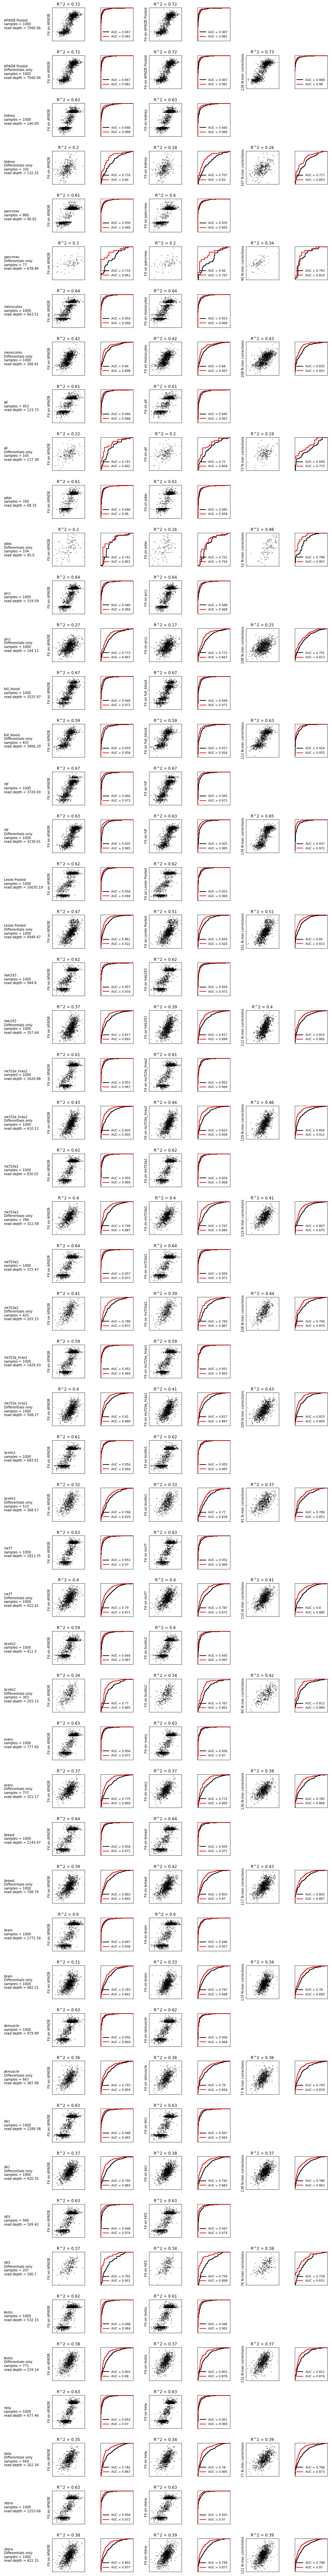

In [26]:
#Plot multiplex results

max_n_members = 1000
show_used_sample_stats_only = True

combined_tissue_index = ['apadb_pooled']
for tissue in apadb_tissue_index :
    combined_tissue_index.append('apadb_' + tissue)
combined_tissue_index.append('leslie_pooled')
for tissue in leslie_tissue_index :
    combined_tissue_index.append('leslie_' + tissue)


n_rows = 2 * len(combined_tissue_index)
n_cols = 7

fig, ax = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue.replace('apadb_pooled', 'APADB Pooled').replace('leslie_pooled', 'Leslie Pooled').replace('apadb_', '').replace('leslie_', '')
    
    #n_samples = min(max_n_members, len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio']))
    n_samples = len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio'])
    avg_reads = round(np.mean(tissue_results_dict['apadb_pooled'][tissue]['y_count']), 1)
    n_samples_diff = len(tissue_results_dict['apadb_pooled_differential'][tissue]['y_ratio'])
    avg_reads_diff = round(np.mean(tissue_results_dict['apadb_pooled_differential'][tissue]['y_count']), 1)
    
    plt.sca(ax[2 * tissue_i, 0])
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.sca(ax[2 * tissue_i + 1, 0])
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled'] :
        tissue_results = tissue_results_dict['apadb_pooled'][tissue]
        n_samples_used, avg_reads_used = plot_tissue_result('Fit on APADB', tissue_results, ax[2 * tissue_i, 1], ax[2 * tissue_i, 2], max_n_members)
        
        if show_used_sample_stats_only :
            n_samples = n_samples_used
            avg_reads = avg_reads_used
    
    #Fitted on tissue
    if tissue in tissue_results_dict and tissue in tissue_results_dict[tissue] :
        tissue_results = tissue_results_dict[tissue][tissue]
        plot_tissue_result('Fit on ' + tissue_name, tissue_results, ax[2 * tissue_i, 3], ax[2 * tissue_i, 4], max_n_members)
    
    #Differentials only
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled_differential'] :
        tissue_results = tissue_results_dict['apadb_pooled_differential'][tissue]
        n_samples_used, avg_reads_used = plot_tissue_result('Fit on APADB', tissue_results, ax[2 * tissue_i + 1, 1], ax[2 * tissue_i + 1, 2], max_n_members)
        
        if show_used_sample_stats_only :
            n_samples_diff = n_samples_used
            avg_reads_diff = avg_reads_used
    
    #Fitted on tissue
    if tissue + '_differential' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_differential'] :
        tissue_results = tissue_results_dict[tissue + '_differential'][tissue]
        plot_tissue_result('Fit on ' + tissue_name, tissue_results, ax[2 * tissue_i + 1, 3], ax[2 * tissue_i + 1, 4], max_n_members)
    
    
    #N-mer corrections, Differentials only
    #Fitted on tissue
    plt.sca(ax[2 * tissue_i, 5])
    plt.axis('off')
    plt.sca(ax[2 * tissue_i, 6])
    plt.axis('off')
    if tissue + '_nmer' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_nmer'] :
        tissue_results = tissue_results_dict[tissue + '_nmer'][tissue]
        plot_tissue_result(str(tissue_results['num_nmers']) + ' N-mer corrections', tissue_results, ax[2 * tissue_i + 1, 5], ax[2 * tissue_i + 1, 6], max_n_members)
    
    
    annot_text = tissue_name + '\n'
    annot_text += 'samples = ' + str(n_samples) + '\n'
    annot_text += 'read depth = ' + str(round(avg_reads, 2))
    ax[2 * tissue_i, 0].text(0.01, 0.5, annot_text, verticalalignment='center', horizontalalignment='left', transform=ax[2 * tissue_i, 0].transAxes, fontsize=10)
    
    annot_text = tissue_name + '\n'
    annot_text += 'Differentials only\n'
    annot_text += 'samples = ' + str(n_samples_diff) + '\n'
    annot_text += 'read depth = ' + str(round(avg_reads_diff, 2))
    ax[2 * tissue_i + 1, 0].text(0.01, 0.5, annot_text, verticalalignment='center', horizontalalignment='left', transform=ax[2 * tissue_i + 1, 0].transAxes, fontsize=10)

plt.tight_layout()
plt.show()


In [37]:
def get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=False) :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds'])
    y_ratio_tissue = np.ravel(tissue_results['y_ratio'])
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_hat'])
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_hat'])
    y_count_tissue = np.ravel(tissue_results['y_count'])
    
    if use_test :
        y_logodds_tissue = np.ravel(tissue_results['y_logodds_test'])
        y_ratio_tissue = np.ravel(tissue_results['y_ratio_test'])
        y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_test_hat'])
        y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_test_hat'])
        y_count_tissue = np.ravel(tissue_results['y_count_test'])

    if max_n_members is not None :
        sort_index = np.argsort(y_count_tissue)[::-1]
        y_count_tissue = y_count_tissue[sort_index[:max_n_members]]
        y_ratio_tissue = y_ratio_tissue[sort_index[:max_n_members]]
        y_ratio_tissue_hat = y_ratio_tissue_hat[sort_index[:max_n_members]]
        y_logodds_tissue = y_logodds_tissue[sort_index[:max_n_members]]
        y_logodds_tissue_hat = y_logodds_tissue_hat[sort_index[:max_n_members]]

    r_val, p_val = pearsonr(y_logodds_tissue_hat, y_logodds_tissue)
    r_val_ratio, _ = pearsonr(y_ratio_tissue_hat, y_ratio_tissue)

    y_label_tissue = np.zeros(y_ratio_tissue.shape[0])
    y_label_tissue[y_ratio_tissue <= 0.5] = 0
    y_label_tissue[y_ratio_tissue > 0.5] = 1

    fpr, tpr, _ = roc_curve(y_label_tissue, y_ratio_tissue_hat)
    auc = roc_auc_score(y_label_tissue, y_ratio_tissue_hat)
    
    fpr_highconf, tpr_highconf, _ = roc_curve(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])
    auc_highconf = roc_auc_score(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])

    n_samples = len(y_ratio_tissue)
    avg_reads = np.mean(y_count_tissue)
    
    if not highconf_only :
        return round(r_val * r_val, 2), round(auc, 2), fpr, tpr, n_samples, avg_reads, round(r_val_ratio * r_val_ratio, 2)
    else :
        return round(r_val * r_val, 2), round(auc_highconf, 2), fpr_highconf, tpr_highconf, n_samples, avg_reads, round(r_val_ratio * r_val_ratio, 2)

def get_summary_nodf(y_logodds_tissue, y_logodds_tissue_hat, y_ratio_tissue, y_ratio_tissue_hat, y_count_tissue, highconf_only) :
    r_val, p_val = pearsonr(y_logodds_tissue_hat, y_logodds_tissue)

    y_label_tissue = np.zeros(y_ratio_tissue.shape[0])
    y_label_tissue[y_ratio_tissue <= 0.5] = 0
    y_label_tissue[y_ratio_tissue > 0.5] = 1

    fpr, tpr, _ = roc_curve(y_label_tissue, y_ratio_tissue_hat)
    auc = roc_auc_score(y_label_tissue, y_ratio_tissue_hat)
    
    fpr_highconf, tpr_highconf, _ = roc_curve(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])
    auc_highconf = roc_auc_score(y_label_tissue[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)], y_ratio_tissue_hat[(y_ratio_tissue <= 0.25) | (y_ratio_tissue >= 0.75)])

    n_samples = len(y_ratio_tissue)
    avg_reads = np.mean(y_count_tissue)
    
    if not highconf_only :
        return round(r_val * r_val, 2), round(auc, 3), fpr, tpr, n_samples, avg_reads
    else :
        return round(r_val * r_val, 2), round(auc_highconf, 3), fpr_highconf, tpr_highconf, n_samples, avg_reads


In [47]:
#Summarize multiplex results

max_n_members = 1000
highconf_only = True
show_used_sample_stats_only = False#True

apadb_blacklist = {}
leslie_blacklist = {'mcf10a1' : True, 'mcf10a_hras1' : True, 'bcells1' : True}

combined_tissue_index = ['apadb_pooled']
for tissue in apadb_tissue_index :
    if tissue not in apadb_blacklist :
        combined_tissue_index.append('apadb_' + tissue)
combined_tissue_index.append('leslie_pooled')
for tissue in leslie_tissue_index :
    if tissue not in leslie_blacklist :
        combined_tissue_index.append('leslie_' + tissue)


r2_tissues_ratios = np.zeros(len(combined_tissue_index))
r2_tissues = np.zeros(len(combined_tissue_index))
r2_tissues_differential = np.zeros(len(combined_tissue_index))
r2_tissues_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_ratios_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_differential_fitted = np.zeros(len(combined_tissue_index))

auc_tissues = np.zeros(len(combined_tissue_index))
auc_tissues_differential = np.zeros(len(combined_tissue_index))
auc_tissues_fitted = np.zeros(len(combined_tissue_index))
auc_tissues_differential_fitted = np.zeros(len(combined_tissue_index))

roc_tissues = []
roc_tissues_differential = []
roc_tissues_fitted = []
roc_tissues_differential_fitted = []

tissue_names = []

n_samples_list = []
n_samples_differential_list = []
avg_reads_list = []
avg_reads_differential_list = []

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue.replace('apadb_pooled', 'APADB Pooled').replace('leslie_pooled', 'Leslie Pooled').replace('apadb_', '').replace('leslie_', '')
    
    n_samples = len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio'])
    avg_reads = round(np.mean(tissue_results_dict['apadb_pooled'][tissue]['y_count']), 1)
    n_samples_diff = len(tissue_results_dict['apadb_pooled_differential'][tissue]['y_ratio'])
    avg_reads_diff = round(np.mean(tissue_results_dict['apadb_pooled_differential'][tissue]['y_count']), 1)
    
    tissue_names.append(tissue_name)
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled'] :
        tissue_results = tissue_results_dict['apadb_pooled'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues[tissue_i] = r2
        r2_tissues_ratios[tissue_i] = r2_ratios
        auc_tissues[tissue_i] = auc
        roc_tissues.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples = n_samples_used
            avg_reads = avg_reads_used
        
    
    #Fitted on tissue
    if tissue in tissue_results_dict and tissue in tissue_results_dict[tissue] :
        tissue_results = tissue_results_dict[tissue][tissue]
        r2, auc, fpr, tpr, _, _, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues_fitted[tissue_i] = r2
        r2_tissues_ratios_fitted[tissue_i] = r2_ratios
        auc_tissues_fitted[tissue_i] = auc
        roc_tissues_fitted.append((fpr, tpr))
    
    #Differentials only
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled_differential'] :
        tissue_results = tissue_results_dict['apadb_pooled_differential'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues_differential[tissue_i] = r2
        auc_tissues_differential[tissue_i] = auc
        roc_tissues_differential.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples_diff = n_samples_used
            avg_reads_diff = avg_reads_used
    
    #Fitted on tissue
    if tissue + '_differential' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_differential'] :
        tissue_results = tissue_results_dict[tissue + '_differential'][tissue]
        r2, auc, fpr, tpr, _, _, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only)
        r2_tissues_differential_fitted[tissue_i] = r2
        auc_tissues_differential_fitted[tissue_i] = auc
        roc_tissues_differential_fitted.append((fpr, tpr))
    
    n_samples_list.append(n_samples)
    n_samples_differential_list.append(n_samples_diff)
    avg_reads_list.append(avg_reads)
    avg_reads_differential_list.append(avg_reads_diff)



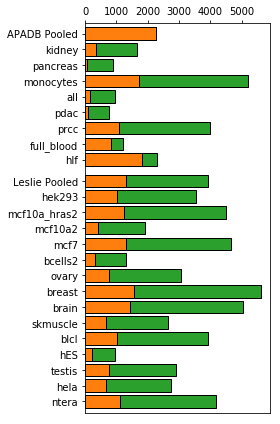

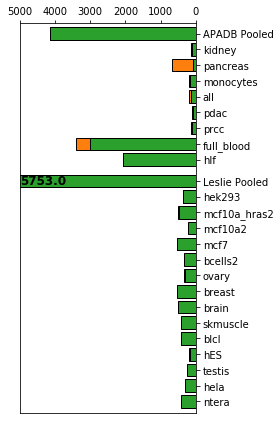

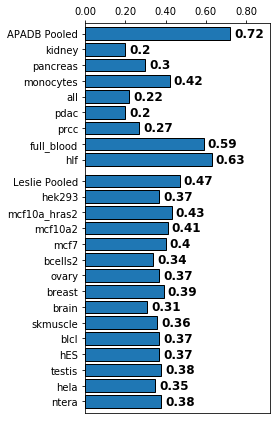

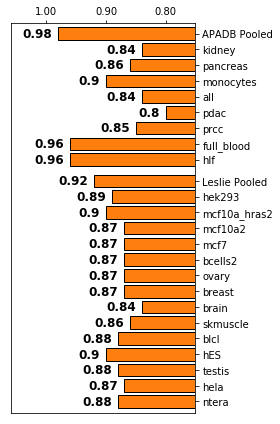

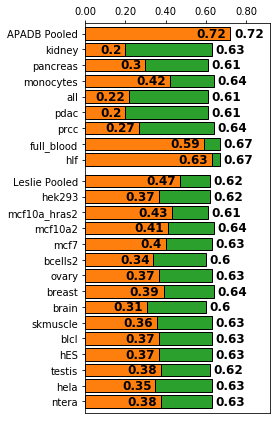

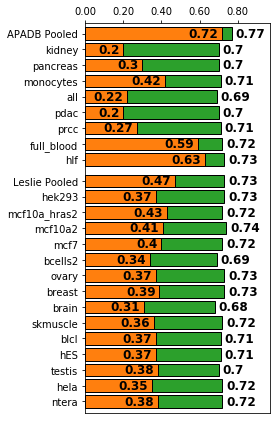

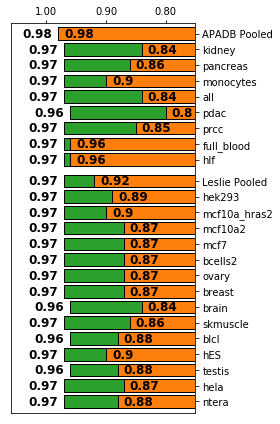

In [49]:
apadb_leslie_separator = 15


#Plot n_samples


y_coords = np.concatenate([np.arange(len(tissue_names))[:apadb_leslie_separator], np.arange(len(tissue_names))[apadb_leslie_separator:] + 0.35])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#Plot r2, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, n_samples_list[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, n_samples_differential_list[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

'''for i, v in zip(y_coords, n_samples_list[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, n_samples_differential_list[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')
'''
plt.yticks(y_coords, tissue_names[::-1])

#plt.xlim(0, np.max(n_samples_list) + 0.2)
plt.ylim(-0.75, len(tissue_names))

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('num_samples_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('num_samples_bar_all_tissues.eps')
plt.savefig('num_samples_bar_all_tissues.svg')

plt.show()



f = plt.figure(figsize=(4, 6))

max_cutoff = 5000
plt.barh(y_coords, avg_reads_differential_list[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

plt.barh(y_coords, avg_reads_list[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, np.round(avg_reads_list[::-1], 0)):
    if v > max_cutoff :
        plt.gca().text(max_cutoff - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
#for i, v in zip(y_coords, np.round(avg_reads_differential_list[::-1], 0)):
#    plt.gca().text(v - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

#plt.xlim(0, np.min(avg_reads_list) - 0.05)
plt.xlim(max_cutoff, 0)
plt.ylim(-0.75, len(tissue_names))

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('avg_reads_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('avg_reads_bar_all_tissues.eps')
plt.savefig('avg_reads_bar_all_tissues.svg')

plt.show()










y_coords = np.concatenate([np.arange(len(tissue_names))[:apadb_leslie_separator], np.arange(len(tissue_names))[apadb_leslie_separator:] + 0.35])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#Plot r2, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[0], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_differential) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('cross_validation_r2_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('cross_validation_r2_bar_all_tissues_both_used.svg')

plt.show()



#Plot aucs, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(auc_tissues_differential) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('cross_validation_auc_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('cross_validation_auc_bar_all_tissues_both_used.svg')

plt.show()








#Plot r2

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('cross_validation_r2_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('cross_validation_r2_bar_all_tissues.svg')

plt.show()




#Plot r2 ratios

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_ratios[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_ratios[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_ratios) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('cross_validation_r2_ratios_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('cross_validation_r2_ratios_bar_all_tissues.svg')

plt.show()




#Plot aucs

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')
for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(np.concatenate([auc_tissues_differential, auc_tissues])) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('cross_validation_auc_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('cross_validation_auc_bar_all_tissues.svg')

plt.show()


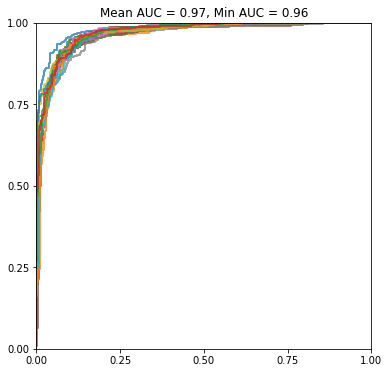

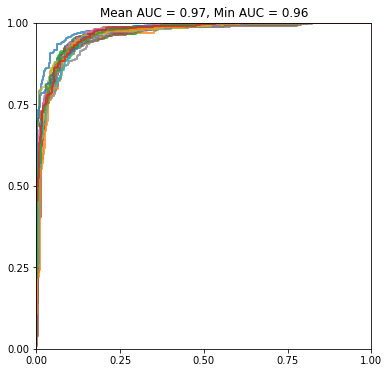

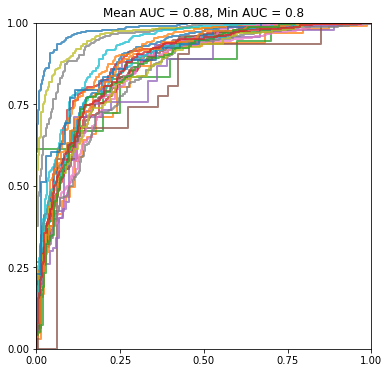

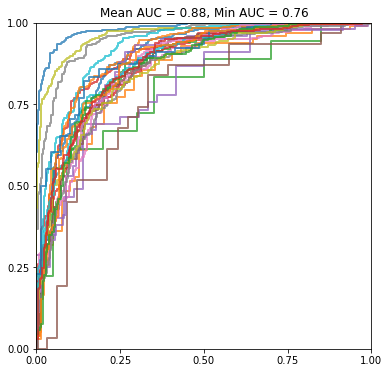

In [154]:
#Plot ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues[tissue_i]
    fpr, tpr = roc_tissues[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')
    
    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('cross_validation_roc_all_tissues_all_sites.png', dpi=150, transparent=True)
plt.savefig('cross_validation_roc_all_tissues_all_sites.svg')

plt.show()

#Plot Fitted ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_fitted[tissue_i]
    fpr, tpr = roc_tissues_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()



#Plot ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential[tissue_i]
    fpr, tpr = roc_tissues_differential[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('cross_validation_roc_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('cross_validation_roc_all_tissues_both_used.svg')

plt.show()

#Plot Fitted ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential_fitted[tissue_i]
    fpr, tpr = roc_tissues_differential_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()

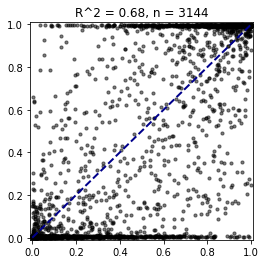

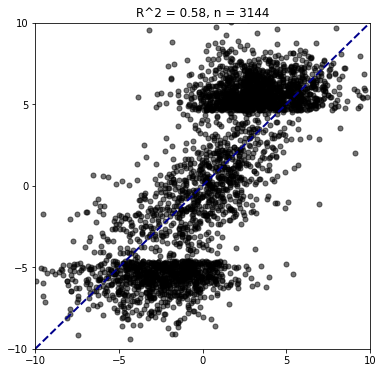

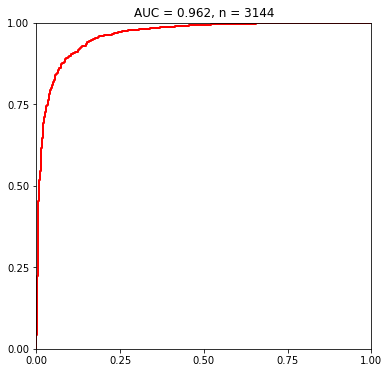

In [241]:
#Plot indivudual tissue result

max_n_members = 10000
highconf_only = True
save_figs = False

data_version = 'cross_validation'

source = 'leslie'
tissue = 'hek293'
special_mode = '_apadb_region'

tissue_results = tissue_results_dict['apadb_pooled'][source + '_' + tissue]

df_tissue = tissue_results['df'].copy()
if data_version == 'test' :
    df_tissue = tissue_results['df_test'].copy()
df_tissue['row_index'] = np.arange(len(df_tissue), dtype=np.int)

#Additional filters

additional_filter = True
site_nums = None#[1]#[1, 2, 3, 4]
site_types = ['UTR3', 'Extension']
pseudo_count = 0.5
min_total_count = 50#1000#500#20
max_cut_region = 60
min_distance = 40
max_distance = 4000

total_count_col = source + '_pair_count' + special_mode + '_' + tissue

#Apply global pre-filters
df_to_use = df_tissue.query(total_count_col + " >= " + str(min_total_count))
df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]
df_to_use = df_to_use.query("(cut_end_prox - cut_start_prox <= " + str(max_cut_region) + ") and (cut_end_dist - cut_start_dist <= " + str(max_cut_region) + ")")
df_to_use = df_to_use.query("(distance >= " + str(min_distance) + ") and (distance <= " + str(max_distance) + ")")

df_to_use = df_to_use.query("mirna_prox == mirna_dist")
df_to_use = df_to_use.query("mirna_prox == 'None' and mirna_dist == 'None'")

keep_index = np.ravel(df_to_use['row_index'])

if data_version != 'test' :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds'])[keep_index]
    y_ratio_tissue = np.ravel(tissue_results['y_ratio'])[keep_index]
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_hat'])[keep_index]
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_hat'])[keep_index]
    y_count_tissue = np.ravel(tissue_results['y_count'])[keep_index]
else :
    y_logodds_tissue = np.ravel(tissue_results['y_logodds_test'])[keep_index]
    y_ratio_tissue = np.ravel(tissue_results['y_ratio_test'])[keep_index]
    y_logodds_tissue_hat = np.ravel(tissue_results['y_logodds_test_hat'])[keep_index]
    y_ratio_tissue_hat = np.ravel(tissue_results['y_ratio_test_hat'])[keep_index]
    y_count_tissue = np.ravel(tissue_results['y_count_test'])[keep_index]

if max_n_members is not None :
    sort_index = np.argsort(y_count_tissue)[::-1]
    y_count_tissue = y_count_tissue[sort_index[:max_n_members]]
    y_ratio_tissue = y_ratio_tissue[sort_index[:max_n_members]]
    y_ratio_tissue_hat = y_ratio_tissue_hat[sort_index[:max_n_members]]
    y_logodds_tissue = y_logodds_tissue[sort_index[:max_n_members]]
    y_logodds_tissue_hat = y_logodds_tissue_hat[sort_index[:max_n_members]]

r2, auc, fpr, tpr, n_samples_used, avg_reads_used = get_summary_nodf(y_logodds_tissue, y_logodds_tissue_hat, y_ratio_tissue, y_ratio_tissue_hat, y_count_tissue, highconf_only)




#Plot ratio scatter

ratio_r_val, _ = pearsonr(y_ratio_tissue_hat, y_ratio_tissue)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_ratio_tissue_hat, y_ratio_tissue, c = 'black', s=10, alpha=0.5)
plt.plot([0, 1], [0, 1], color='darkblue', linewidth=2, linestyle='--')

plt.xlim(0-0.01, 1+0.01)
plt.ylim(0-0.01, 1+0.01)

plt.title('R^2 = ' + str(round(ratio_r_val * ratio_r_val, 2)) + ', n = ' + str(y_ratio_tissue.shape[0]))

if save_figs :
    plt.savefig(data_version + '_ratios_' + source + '_' + tissue + '.png', dpi=150, transparent=True)
    plt.savefig(data_version + '_ratios_' + source + '_' + tissue + '.svg')

plt.show()

#Plot Cross-validation R^2

f = plt.figure(figsize=(6, 6))

xlim = [-10, 10]
ylim = [-10, 10]

plt.scatter(y_logodds_tissue_hat, y_logodds_tissue, c = 'black', s = 1 * np.pi * (2 * np.ones(1))**3, alpha=0.55)
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color='darkblue', linewidth=2, linestyle='--')

plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])

plt.xticks([xlim[0], -5, 0, 5, xlim[1]])
plt.yticks([ylim[0], -5, 0, 5, ylim[1]])

plt.title('R^2 = ' + str(r2) + ', n = ' + str(y_logodds_tissue.shape[0]))

if save_figs :
    plt.savefig(data_version + '_scatter_' + source + '_' + tissue + '.png', dpi=150, transparent=True)
    plt.savefig(data_version + '_scatter_' + source + '_' + tissue + '.svg')

plt.show()

#Plot Cross-validation ROC

f = plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, color='red', linewidth=2, linestyle='-')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.title('AUC = ' + str(auc) + ', n = ' + str(y_logodds_tissue.shape[0]))

if save_figs :
    plt.savefig(data_version + '_roc_' + source + '_' + tissue + '.png', dpi=150, transparent=True)
    plt.savefig(data_version + '_roc_' + source + '_' + tissue + '.svg')

plt.show()


In [299]:
#Summarize multiplex results, test set only

max_n_members = 1000
highconf_only = True
show_used_sample_stats_only = True

combined_tissue_index = ['apadb_pooled']
for tissue in apadb_tissue_index :
    if tissue not in apadb_blacklist :
        combined_tissue_index.append('apadb_' + tissue)
combined_tissue_index.append('leslie_pooled')
for tissue in leslie_tissue_index :
    if tissue not in leslie_blacklist :
        combined_tissue_index.append('leslie_' + tissue)


r2_tissues_ratios = np.zeros(len(combined_tissue_index))
r2_tissues = np.zeros(len(combined_tissue_index))
r2_tissues_differential = np.zeros(len(combined_tissue_index))
r2_tissues_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_ratios_fitted = np.zeros(len(combined_tissue_index))
r2_tissues_differential_fitted = np.zeros(len(combined_tissue_index))

auc_tissues = np.zeros(len(combined_tissue_index))
auc_tissues_differential = np.zeros(len(combined_tissue_index))
auc_tissues_fitted = np.zeros(len(combined_tissue_index))
auc_tissues_differential_fitted = np.zeros(len(combined_tissue_index))
auc_tissues_differential_nmers_fitted = np.zeros(len(combined_tissue_index))

roc_tissues = []
roc_tissues_differential = []
roc_tissues_fitted = []
roc_tissues_differential_fitted = []
roc_tissues_differential_nmers_fitted = []

tissue_names = []

n_samples_list = []
n_samples_differential_list = []
avg_reads_list = []
avg_reads_differential_list = []

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue.replace('apadb_pooled', 'APADB Pooled').replace('leslie_pooled', 'Leslie Pooled').replace('apadb_', '').replace('leslie_', '')
    
    n_samples = len(tissue_results_dict['apadb_pooled'][tissue]['y_ratio'])
    avg_reads = round(np.mean(tissue_results_dict['apadb_pooled'][tissue]['y_count']), 1)
    n_samples_diff = len(tissue_results_dict['apadb_pooled_differential'][tissue]['y_ratio'])
    avg_reads_diff = round(np.mean(tissue_results_dict['apadb_pooled_differential'][tissue]['y_count']), 1)
    
    tissue_names.append(tissue_name)
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled'] :
        tissue_results = tissue_results_dict['apadb_pooled'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues[tissue_i] = r2
        r2_tissues_ratios[tissue_i] = r2_ratios
        auc_tissues[tissue_i] = auc
        roc_tissues.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples = n_samples_used
            avg_reads = avg_reads_used
        
    
    #Fitted on tissue
    if tissue in tissue_results_dict and tissue in tissue_results_dict[tissue] :
        tissue_results = tissue_results_dict[tissue][tissue]
        r2, auc, fpr, tpr, _, _, r2_ratios = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues_fitted[tissue_i] = r2
        r2_tissues_ratios_fitted[tissue_i] = r2_ratios
        auc_tissues_fitted[tissue_i] = auc
        roc_tissues_fitted.append((fpr, tpr))
    
    #Differentials only
    
    #Fitted on APADB pooled
    if tissue in tissue_results_dict['apadb_pooled_differential'] :
        tissue_results = tissue_results_dict['apadb_pooled_differential'][tissue]
        r2, auc, fpr, tpr, n_samples_used, avg_reads_used, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues_differential[tissue_i] = r2
        auc_tissues_differential[tissue_i] = auc
        roc_tissues_differential.append((fpr, tpr))
        
        if show_used_sample_stats_only :
            n_samples_diff = n_samples_used
            avg_reads_diff = avg_reads_used
    
    #Fitted on tissue
    if tissue + '_differential' in tissue_results_dict and tissue in tissue_results_dict[tissue + '_differential'] :
        tissue_results = tissue_results_dict[tissue + '_differential'][tissue]
        r2, auc, fpr, tpr, _, _, _ = get_summary(tissue_name, tissue_results, max_n_members, highconf_only, use_test=True)
        r2_tissues_differential_fitted[tissue_i] = r2
        auc_tissues_differential_fitted[tissue_i] = auc
        roc_tissues_differential_fitted.append((fpr, tpr))
    
    n_samples_list.append(n_samples)
    n_samples_differential_list.append(n_samples_diff)
    avg_reads_list.append(avg_reads)
    avg_reads_differential_list.append(avg_reads_diff)



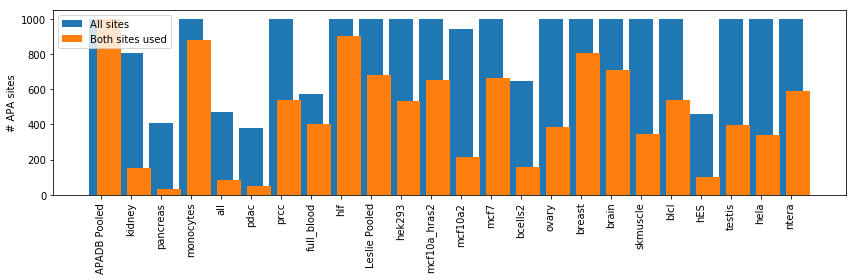

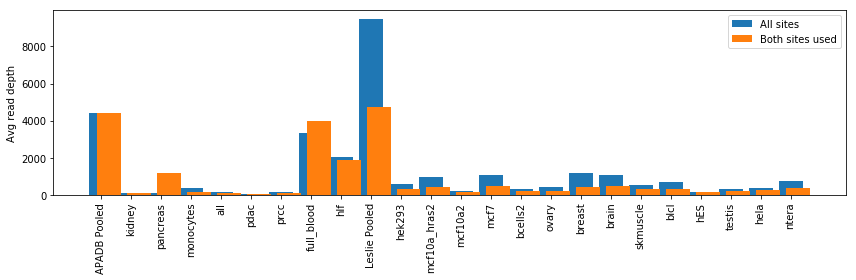

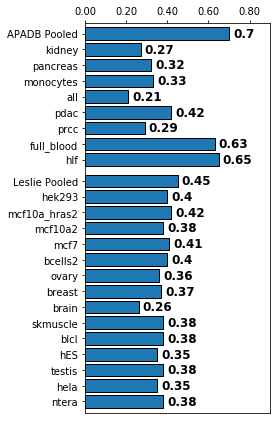

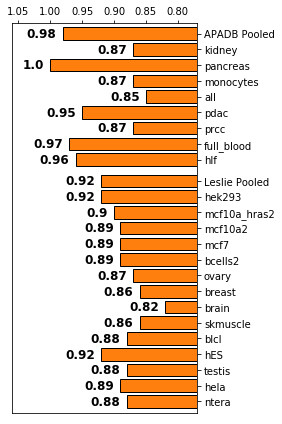

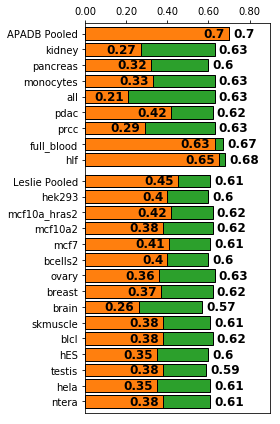

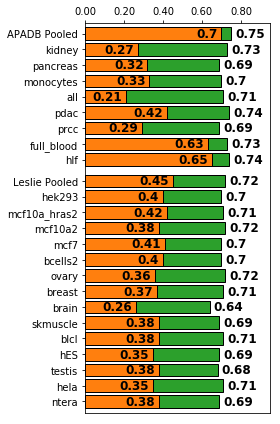

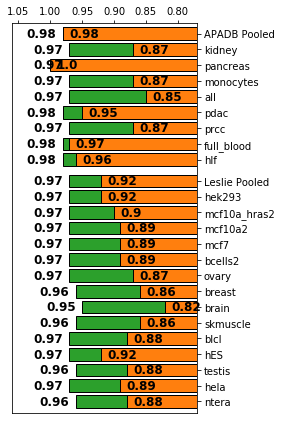

In [300]:

#Plot n_samples

f = plt.figure(figsize=(12, 4))

ls = []

plt.bar(np.arange(len(tissue_names)), n_samples_list, label='All sites')

plt.bar(np.arange(len(tissue_names)) + 0.25, n_samples_differential_list, label='Both sites used')

plt.xticks(np.arange(len(tissue_names)), tissue_names, rotation=90)

plt.ylabel('# APA sites')

plt.legend()

plt.tight_layout()
plt.show()

#Plot avg_reads

f = plt.figure(figsize=(12, 4))

ls = []

plt.bar(np.arange(len(tissue_names)), avg_reads_list, label='All sites')

plt.bar(np.arange(len(tissue_names)) + 0.25, avg_reads_differential_list, label='Both sites used')

plt.xticks(np.arange(len(tissue_names)), tissue_names, rotation=90)

plt.ylabel('Avg read depth')

plt.legend()

plt.tight_layout()
plt.show()







apadb_leslie_separator = 15

y_coords = np.concatenate([np.arange(len(tissue_names))[:apadb_leslie_separator], np.arange(len(tissue_names))[apadb_leslie_separator:] + 0.35])


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#Plot r2, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[0], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_differential) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('test_r2_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('test_r2_bar_all_tissues_both_used.svg')

plt.show()



#Plot aucs, differentials only

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(auc_tissues_differential) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('test_auc_bar_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('test_auc_bar_all_tissues_both_used.svg')

plt.show()








#Plot r2

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('test_r2_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('test_r2_bar_all_tissues.svg')

plt.show()




#Plot r2 ratios

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, r2_tissues_ratios[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, r2_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, r2_tissues_ratios[::-1]):
    plt.gca().text(v + 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')
for i, v in zip(y_coords, r2_tissues_differential[::-1]):
    plt.gca().text(v - 0.02, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(0, np.max(r2_tissues_ratios) + 0.2)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()

plt.tight_layout()

plt.savefig('test_r2_ratios_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('test_r2_ratios_bar_all_tissues.svg')

plt.show()




#Plot aucs

f = plt.figure(figsize=(4, 6))

plt.barh(y_coords, auc_tissues[::-1], color=colors[2], edgecolor='black', linewidth=1, alpha=1.0)
plt.barh(y_coords, auc_tissues_differential[::-1], color=colors[1], edgecolor='black', linewidth=1, alpha=1.0)

for i, v in zip(y_coords, auc_tissues[::-1]):
    plt.gca().text(v + 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='right', verticalalignment='center')
for i, v in zip(y_coords, auc_tissues_differential[::-1]):
    plt.gca().text(v - 0.01, i, str(v), color='black', fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

plt.yticks(y_coords, tissue_names[::-1])

plt.xlim(1.06, np.min(np.concatenate([auc_tissues_differential, auc_tissues])) - 0.05)
plt.ylim(-0.75, len(tissue_names))

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()

plt.tight_layout()

plt.savefig('test_auc_bar_all_tissues.png', dpi=150, transparent=True)
plt.savefig('test_auc_bar_all_tissues.svg')

plt.show()


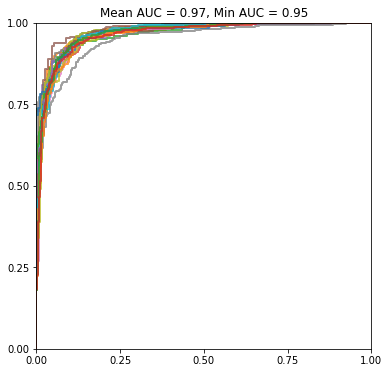

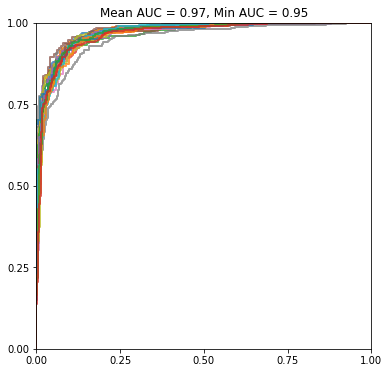

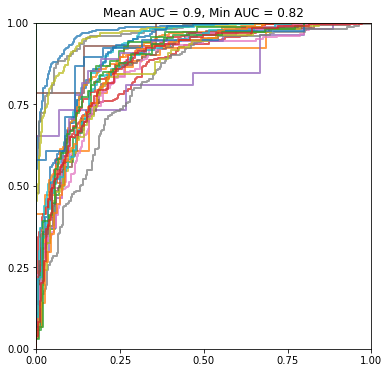

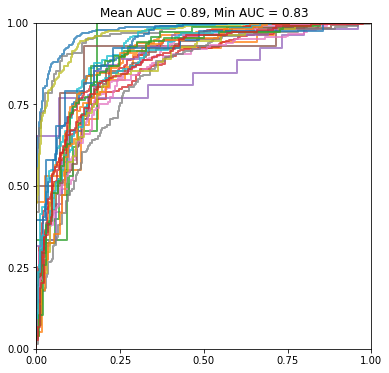

In [301]:
#Plot ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues[tissue_i]
    fpr, tpr = roc_tissues[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')
    
    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('test_roc_all_tissues_all_sites.png', dpi=150, transparent=True)
plt.savefig('test_roc_all_tissues_all_sites.svg')

plt.show()

#Plot Fitted ROCs

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_fitted[tissue_i]
    fpr, tpr = roc_tissues_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()



#Plot ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential[tissue_i]
    fpr, tpr = roc_tissues_differential[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()

plt.savefig('test_roc_all_tissues_both_used.png', dpi=150, transparent=True)
plt.savefig('test_roc_all_tissues_both_used.svg')

plt.show()

#Plot Fitted ROCs, differentials only

f = plt.figure(figsize=(6, 6))

min_auc = 1
mean_auc = 0

for tissue_i, tissue in enumerate(combined_tissue_index) :
    
    tissue_name = tissue_names[tissue_i]
    auc = auc_tissues_differential_fitted[tissue_i]
    fpr, tpr = roc_tissues_differential_fitted[tissue_i]
    
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75, label=tissue_name + '(AUC = ' + str(auc) + ')')

    min_auc = min(min_auc, auc)
    mean_auc += auc

mean_auc /= float(len(combined_tissue_index))
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])

#plt.tight_layout()
plt.show()

In [167]:
#Fit model on APADB

X_apadb, y_ratio_apadb, y_logodds_apadb, _, _ = get_data(df_all, 'apadb', 'pooled', '', '_apadb_region', pseudo_count=0.5, min_total_count=count_filters['apadb_pooled'], only_differentials=True)

_, _, _, _, w_bundle_linear = fit_linear_model(X_apadb, y_logodds_apadb, X_apadb, y_logodds_apadb, l2_lambda=None, l1_lambda=None)
w_linear, w_linear_0 = w_bundle_linear

_, _, _, _, w_bundle_logistic = fit_logistic_model(X_apadb, y_ratio_apadb, X_apadb, y_ratio_apadb, l2_lambda=0.0)
w_logistic, w_logistic_0 = w_bundle_logistic


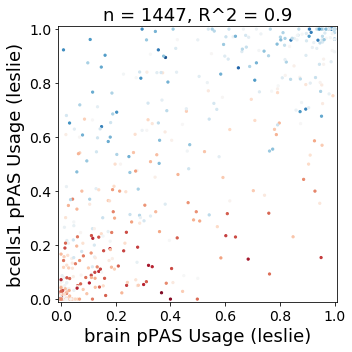

In [219]:
#Differential pairwise site usage analysis, individual scatters

site_nums = [1, 2]#None#[1, 2, 3, 4, 5]
prox_site_types = ['UTR3', 'Extension']#, , 'Extension'
dist_site_types = ['UTR3', 'Extension']#, , 'Extension'
pseudo_count = 0.0
min_total_count = 20#100
only_differentials = False
use_logodds = False
color_by_sitenum = False

pred_special_mode = '_apadb_region'

source_data_1 = 'leslie'
tissue_1 = 'brain'
special_mode_1 = '_apadb_region'

source_data_2 = 'leslie'
tissue_2 = 'bcells1'
special_mode_2 = '_apadb_region' #_apadb_region

count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
#df_to_use = df_to_use.query(count_col_1 + " / " + total_count_col_1 + " != " + count_col_2 + " / " + total_count_col_2)

df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(prox_site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(dist_site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
    df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

true_metric_tissue_1 = np.ravel((df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count))
true_metric_tissue_2 = np.ravel((df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count))


prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)
X = np.concatenate([
    prox_score,
    dist_score,
    distance,
], axis=1)

pred_metric = predict_logistic_model(X, w_logistic, w_logistic_0)



if use_logodds :
    true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
    true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))
    pred_metric = predict_linear_model(X, w_linear, w_linear_0)

r_val, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)

f = plt.figure(figsize=(5, 5))

if not color_by_sitenum :
    #plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=1.0, s=5, c='black')
    
    plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=1.0, s=5, c=(pred_metric - true_metric_tissue_2), cmap='RdBu_r')
    
else :
    sitenums = np.ravel(df_to_use['sitenum'].values)
    for sitenum in np.unique(sitenums) :
        if np.any(sitenums == sitenum) :
            plt.scatter(true_metric_tissue_1[sitenums == sitenum], true_metric_tissue_2[sitenums == sitenum], label='Site ' + str(sitenum), alpha=0.25, s=5)

    plt.legend(fontsize=14, frameon=True, framealpha=0.5, loc='lower right')

plt.xlabel(tissue_1.replace('_', ' ') + ' pPAS Usage (' + source_data_1 + ')', fontsize=18)
plt.ylabel(tissue_2.replace('_', ' ') + ' pPAS Usage (' + source_data_2 + ')', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if not use_logodds :
    plt.xlim(0-0.01, 1+0.01)
    plt.ylim(0-0.01, 1+0.01)

plt.title('n = ' + str(len(df_to_use)) + ', R^2 = ' + str(round(r_val * r_val, 2)), fontsize=18)

plt.tight_layout()
plt.show()


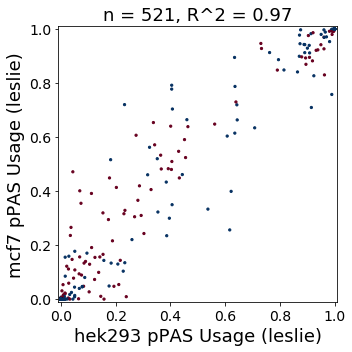

In [242]:
#Differential pairwise site usage analysis, individual scatters

site_nums = [1]#None#[1, 2]#None#[1, 2, 3, 4, 5]
prox_site_types = ['UTR3', 'Extension']#, , 'Extension'
dist_site_types = ['UTR3', 'Extension']#, , 'Extension'
pseudo_count = 0.0
min_total_count = 100#100
only_differentials = False
use_logodds = False
color_by_sitenum = False

pred_special_mode = '_apadb_region'

source_data_1 = 'leslie'
tissue_1 = 'hek293'
special_mode_1 = '_apadb_region'

source_data_2 = 'leslie'
tissue_2 = 'mcf7'
special_mode_2 = '_apadb_region' #_apadb_region

count_col_1 = source_data_1 + '_count' + special_mode_1 + '_' + tissue_1 + '_prox'
count_col_2 = source_data_2 + '_count' + special_mode_2 + '_' + tissue_2 + '_prox'
total_count_col_1 = source_data_1 + '_pair_count' + special_mode_1 + '_' + tissue_1
total_count_col_2 = source_data_2 + '_pair_count' + special_mode_2 + '_' + tissue_2
df_to_use = df_pair_filtered.query(total_count_col_1 + " >= " + str(min_total_count) + " and " + total_count_col_2 + " >= " + str(min_total_count))
#df_to_use = df_to_use.query(count_col_1 + " / " + total_count_col_1 + " != " + count_col_2 + " / " + total_count_col_2)

df_to_use = df_to_use.loc[df_to_use.site_type_prox.isin(prox_site_types)]
df_to_use = df_to_use.loc[df_to_use.site_type_dist.isin(dist_site_types)]
if site_nums is not None :
    df_to_use = df_to_use.loc[df_to_use.sitenum_prox.isin(site_nums)]

if only_differentials :
    df_to_use = df_to_use.query(count_col_1 + " != " + total_count_col_1 + " and " + count_col_2 + " != " + total_count_col_2)
    df_to_use = df_to_use.query(count_col_1 + " != 0 and " + count_col_2 + " != 0")

true_metric_tissue_1 = np.ravel((df_to_use[count_col_1] + pseudo_count) / (df_to_use[total_count_col_1] + 2. * pseudo_count))
true_metric_tissue_2 = np.ravel((df_to_use[count_col_2] + pseudo_count) / (df_to_use[total_count_col_2] + 2. * pseudo_count))


prox_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_prox'].values).reshape(-1, 1)
dist_score = np.ravel(df_to_use['predicted_logodds' + pred_special_mode + '_dist'].values).reshape(-1, 1)
distance = np.ravel(np.log(df_to_use['distance'])).reshape(-1, 1)
X = np.concatenate([
    prox_score,
    dist_score,
    distance,
], axis=1)

pred_metric = predict_logistic_model(X, w_logistic, w_logistic_0)



if use_logodds :
    true_metric_tissue_1 = np.log(true_metric_tissue_1 / (1. - true_metric_tissue_1))
    true_metric_tissue_2 = np.log(true_metric_tissue_2 / (1. - true_metric_tissue_2))
    pred_metric = predict_linear_model(X, w_linear, w_linear_0)

r_val, _ = pearsonr(true_metric_tissue_1, true_metric_tissue_2)

f = plt.figure(figsize=(5, 5))

if not color_by_sitenum :
    #plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=0.5, s=5, c='black')
    
    min_cl = np.argmin(np.concatenate([np.abs(pred_metric - true_metric_tissue_1).reshape(-1, 1), np.abs(pred_metric - true_metric_tissue_2).reshape(-1, 1)], axis=1), axis=1)
    
    plt.scatter(true_metric_tissue_1, true_metric_tissue_2, alpha=1.0, s=5, c=min_cl, cmap='RdBu_r')
    
else :
    sitenums = np.ravel(df_to_use['sitenum'].values)
    for sitenum in np.unique(sitenums) :
        if np.any(sitenums == sitenum) :
            plt.scatter(true_metric_tissue_1[sitenums == sitenum], true_metric_tissue_2[sitenums == sitenum], label='Site ' + str(sitenum), alpha=0.25, s=5)

    plt.legend(fontsize=14, frameon=True, framealpha=0.5, loc='lower right')

plt.xlabel(tissue_1.replace('_', ' ') + ' pPAS Usage (' + source_data_1 + ')', fontsize=18)
plt.ylabel(tissue_2.replace('_', ' ') + ' pPAS Usage (' + source_data_2 + ')', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if not use_logodds :
    plt.xlim(0-0.01, 1+0.01)
    plt.ylim(0-0.01, 1+0.01)

plt.title('n = ' + str(len(df_to_use)) + ', R^2 = ' + str(round(r_val * r_val, 2)), fontsize=18)

plt.tight_layout()
plt.show()
